# Soil Property Prediction using Hyperspectral Data
## Using ICRAF-ISRIC Soil VNIR Spectral Library

This notebook adapts hyperspectral classification techniques to predict soil properties using the ICRAF-ISRIC Soil VNIR Spectral Library containing 4,438 soil samples with visible near-infrared spectra and associated soil properties.

The library contains soil samples from 58 countries spanning Africa, Asia, Europe, North America, and South America with associated attribute data including geographical coordinates, horizon depth, and physical/chemical properties.


In [1]:
def calculate_crop_suitability_score(soil_properties):
    """
    Calculate soil suitability score for crop growth based on optimal ranges
    Adapted for available ICRAF dataset columns: pH, Organic_Carbon, Clay_Content, Sand_Content, Silt_Content
    
    Parameters:
    soil_properties: dict containing soil property values
    
    Returns:
    dict with overall score and individual property scores
    """
    
    # Map available columns to standard names for backward compatibility
    property_mapping = {
        'pH': 'pH',
        'Organic_Carbon': 'organic_carbon', 
        'Clay_Content': 'clay',
        'Sand_Content': 'sand',
        'Silt_Content': 'silt'
    }
    
    # Standardize property names
    standardized_properties = {}
    for original_name, standard_name in property_mapping.items():
        if original_name in soil_properties:
            standardized_properties[standard_name] = soil_properties[original_name]
        elif standard_name in soil_properties:
            standardized_properties[standard_name] = soil_properties[standard_name]
    
    # Define optimal ranges for crop growth (using available properties only)
    optimal_ranges = {
        'pH': {'min': 6.0, 'max': 7.0, 'acceptable_min': 5.5, 'acceptable_max': 7.5},
        'organic_carbon': {'min': 1.5, 'max': 3.0, 'acceptable_min': 1.0, 'acceptable_max': 4.0},  # % OC
        'clay': {'min': 15, 'max': 35, 'acceptable_min': 10, 'acceptable_max': 50},  # %
        'sand': {'min': 30, 'max': 60, 'acceptable_min': 20, 'acceptable_max': 70},  # %
        'silt': {'min': 20, 'max': 40, 'acceptable_min': 15, 'acceptable_max': 50}   # %
    }
    
    # Adjusted weights for available properties (higher = more important)
    weights = {
        'pH': 0.50,           # Most critical - increased weight since fewer properties
        'organic_carbon': 0.30,  # Very important for soil health
        'clay': 0.10,         # Affects water retention and nutrients
        'sand': 0.06,         # Affects drainage
        'silt': 0.04          # Affects water retention
    }
    
    property_scores = {}
    weighted_scores = []
    
    for prop, ranges in optimal_ranges.items():
        if prop in standardized_properties and standardized_properties[prop] is not None:
            value = standardized_properties[prop]
            
            # Calculate score based on how close to optimal range
            if ranges['min'] <= value <= ranges['max']:
                score = 100  # Optimal
            elif ranges['acceptable_min'] <= value <= ranges['acceptable_max']:
                # Linear interpolation for acceptable range
                if value < ranges['min']:
                    score = 70 + 30 * (value - ranges['acceptable_min']) / (ranges['min'] - ranges['acceptable_min'])
                else:
                    score = 70 + 30 * (ranges['acceptable_max'] - value) / (ranges['acceptable_max'] - ranges['max'])
            else:
                # Outside acceptable range
                if value < ranges['acceptable_min']:
                    score = max(0, 50 * value / ranges['acceptable_min'])
                else:
                    score = max(0, 50 * ranges['acceptable_max'] / value)
            
            property_scores[prop] = score
            weighted_scores.append(score * weights.get(prop, 0.01))
        else:
            property_scores[prop] = None
    
    # Calculate overall score
    total_weight = sum(weights[prop] for prop in property_scores if property_scores[prop] is not None)
    overall_score = sum(weighted_scores) / total_weight if total_weight > 0 else 0
    
    # Classification based on score
    if overall_score >= 85:
        classification = "Excellent"
    elif overall_score >= 70:
        classification = "Good"
    elif overall_score >= 55:
        classification = "Fair"
    elif overall_score >= 40:
        classification = "Poor"
    else:
        classification = "Very Poor"
    
    return {
        'overall_score': overall_score,
        'classification': classification,
        'property_scores': property_scores,
        'missing_properties': [prop for prop, score in property_scores.items() if score is None]
    }

def rank_soils_for_crops(soil_data):
    """
    Rank soil samples based on their suitability for crop growth
    
    Parameters:
    soil_data: DataFrame with soil properties
    
    Returns:
    DataFrame with added suitability scores and rankings
    """
    
    results = []
    
    for idx, row in soil_data.iterrows():
        # Convert row to dictionary
        soil_props = row.to_dict()
        
        # Calculate suitability score
        suitability = calculate_crop_suitability_score(soil_props)
        
        # Add results
        result = {
            'sample_id': idx,
            'overall_score': suitability['overall_score'],
            'classification': suitability['classification'],
            'missing_properties': len(suitability['missing_properties'])
        }
        
        # Add individual property scores
        for prop, score in suitability['property_scores'].items():
            result[f'{prop}_score'] = score
            
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Rank soils
    results_df['rank'] = results_df['overall_score'].rank(method='dense', ascending=False)
    
    return results_df.sort_values('overall_score', ascending=False)

def identify_limiting_factors(soil_properties):
    """
    Identify which soil properties are most limiting for crop growth
    
    Parameters:
    soil_properties: dict containing soil property values
    
    Returns:
    dict with limiting factors and recommendations
    """
    
    suitability = calculate_crop_suitability_score(soil_properties)
    property_scores = suitability['property_scores']
    
    # Find properties with low scores
    limiting_factors = []
    recommendations = []
    
    for prop, score in property_scores.items():
        if score is not None and score < 60:
            limiting_factors.append((prop, score))
            
            # Add specific recommendations
            if prop == 'pH':
                ph_value = soil_properties.get('pH', 7)
                if ph_value < 6.0:
                    recommendations.append("Apply lime to raise pH")
                elif ph_value > 7.5:
                    recommendations.append("Apply sulfur or organic matter to lower pH")
            elif prop == 'organic_carbon':
                recommendations.append("Add compost or organic matter to increase soil organic carbon")
            elif prop == 'clay':
                clay_value = soil_properties.get('Clay_Content', soil_properties.get('clay', 25))
                if clay_value < 15:
                    recommendations.append("Consider adding clay amendments or organic matter for better nutrient retention")
                elif clay_value > 35:
                    recommendations.append("Improve drainage and consider adding sand or organic matter to reduce compaction")
            elif prop == 'sand':
                sand_value = soil_properties.get('Sand_Content', soil_properties.get('sand', 45))
                if sand_value < 30:
                    recommendations.append("Consider adding sand to improve drainage")
                elif sand_value > 60:
                    recommendations.append("Add organic matter to improve water and nutrient retention")
            elif prop == 'silt':
                recommendations.append("Monitor soil structure and consider organic matter additions")
    
    # Sort by severity (lowest scores first)
    limiting_factors.sort(key=lambda x: x[1])
    
    return {
        'limiting_factors': limiting_factors,
        'recommendations': recommendations,
        'priority_actions': recommendations[:3]  # Top 3 recommendations
    }

def plot_soil_suitability_analysis(results_df, top_n=20):
    """
    Create visualizations for soil suitability analysis
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Distribution of suitability scores
    axes[0,0].hist(results_df['overall_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_xlabel('Suitability Score')
    axes[0,0].set_ylabel('Number of Samples')
    axes[0,0].set_title('Distribution of Soil Suitability Scores')
    axes[0,0].axvline(x=85, color='green', linestyle='--', label='Excellent (85+)')
    axes[0,0].axvline(x=70, color='orange', linestyle='--', label='Good (70+)')
    axes[0,0].axvline(x=55, color='red', linestyle='--', label='Fair (55+)')
    axes[0,0].legend()
    
    # 2. Classification pie chart
    class_counts = results_df['classification'].value_counts()
    axes[0,1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0,1].set_title('Soil Quality Classification Distribution')
    
    # 3. Top soils bar chart
    top_soils = results_df.head(top_n)
    axes[1,0].bar(range(len(top_soils)), top_soils['overall_score'], color='lightgreen')
    axes[1,0].set_xlabel('Soil Sample Rank')
    axes[1,0].set_ylabel('Suitability Score')
    axes[1,0].set_title(f'Top {top_n} Soil Samples by Suitability')
    
    # 4. Property scores heatmap for top soils
    property_cols = [col for col in results_df.columns if col.endswith('_score')]
    if property_cols:
        heatmap_data = top_soils[property_cols].head(10)
        heatmap_data = heatmap_data.fillna(0)  # Fill missing values with 0
        
        # Clean column names for display
        clean_cols = [col.replace('_score', '').replace('_', ' ').title() for col in property_cols]
        heatmap_data.columns = clean_cols
        
        im = axes[1,1].imshow(heatmap_data.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
        axes[1,1].set_xticks(range(len(heatmap_data)))
        axes[1,1].set_xticklabels([f'Sample {i+1}' for i in range(len(heatmap_data))], rotation=45)
        axes[1,1].set_yticks(range(len(clean_cols)))
        axes[1,1].set_yticklabels(clean_cols)
        axes[1,1].set_title('Property Scores for Top 10 Soils')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[1,1], label='Score (0-100)')
    
    plt.tight_layout()
    plt.show()
    
    return fig

print("Crop suitability analysis functions loaded successfully!")


Crop suitability analysis functions loaded successfully!


In [2]:
def get_crop_specific_requirements():
    """
    Define optimal soil requirements for specific crops
    Adapted for available ICRAF dataset columns: pH, Organic_Carbon, Clay_Content, Sand_Content, Silt_Content
    """
    
    crop_requirements = {
        'corn': {
            'pH': {'min': 6.0, 'max': 6.8},
            'organic_carbon': {'min': 2.0, 'max': 4.0},
            'clay': {'min': 20, 'max': 40},  # Good for nutrient retention
            'sand': {'min': 30, 'max': 50},  # Adequate drainage
            'description': 'Prefers well-drained loamy soils with good organic matter'
        },
        'wheat': {
            'pH': {'min': 6.0, 'max': 7.5},
            'organic_carbon': {'min': 1.5, 'max': 3.0},
            'clay': {'min': 15, 'max': 35},  # Adaptable to various textures
            'sand': {'min': 25, 'max': 60},  # Moderate drainage needs
            'description': 'Adaptable to various soils, moderate fertility requirements'
        },
        'soybeans': {
            'pH': {'min': 6.0, 'max': 7.0},
            'organic_carbon': {'min': 2.0, 'max': 3.5},
            'clay': {'min': 18, 'max': 35},  # Good structure for root development
            'sand': {'min': 30, 'max': 55},  # Good drainage important
            'description': 'Fixes nitrogen, needs good drainage and moderate fertility'
        },
        'rice': {
            'pH': {'min': 5.5, 'max': 6.5},
            'organic_carbon': {'min': 2.5, 'max': 4.5},
            'clay': {'min': 25, 'max': 60},  # High clay for water retention
            'sand': {'min': 10, 'max': 40},  # Lower sand for water holding
            'description': 'Tolerates lower pH, adapted to flooded conditions with high clay content'
        },
        'vegetables': {
            'pH': {'min': 6.2, 'max': 7.0},
            'organic_carbon': {'min': 3.0, 'max': 5.0},
            'clay': {'min': 20, 'max': 35},  # Good nutrient holding
            'sand': {'min': 25, 'max': 45},  # Balanced drainage
            'description': 'High fertility requirements, need rich organic soils with good structure'
        }
    }
    
    return crop_requirements

def calculate_crop_specific_suitability(soil_properties, crop_type):
    """
    Calculate soil suitability for a specific crop
    Adapted for available ICRAF dataset columns: pH, Organic_Carbon, Clay_Content, Sand_Content, Silt_Content
    
    Parameters:
    soil_properties: dict containing soil property values
    crop_type: string specifying crop ('corn', 'wheat', 'soybeans', 'rice', 'vegetables')
    
    Returns:
    dict with crop-specific suitability score
    """
    
    # Map available columns to standard names for backward compatibility
    property_mapping = {
        'pH': 'pH',
        'Organic_Carbon': 'organic_carbon', 
        'Clay_Content': 'clay',
        'Sand_Content': 'sand',
        'Silt_Content': 'silt'
    }
    
    # Standardize property names
    standardized_properties = {}
    for original_name, standard_name in property_mapping.items():
        if original_name in soil_properties:
            standardized_properties[standard_name] = soil_properties[original_name]
        elif standard_name in soil_properties:
            standardized_properties[standard_name] = soil_properties[standard_name]
    
    crop_requirements = get_crop_specific_requirements()
    
    if crop_type not in crop_requirements:
        raise ValueError(f"Crop type '{crop_type}' not supported. Available: {list(crop_requirements.keys())}")
    
    requirements = crop_requirements[crop_type]
    
    # Adjusted weights for available properties
    weights = {
        'pH': 0.40,           # Most critical
        'organic_carbon': 0.35,  # Very important for crop productivity
        'clay': 0.15,         # Important for soil structure and nutrients
        'sand': 0.10          # Important for drainage
    }
    
    property_scores = {}
    weighted_scores = []
    
    for prop, ranges in requirements.items():
        if prop == 'description':
            continue
            
        if prop in standardized_properties and standardized_properties[prop] is not None:
            value = standardized_properties[prop]
            
            # Calculate score - tighter ranges for crop-specific requirements
            optimal_center = (ranges['min'] + ranges['max']) / 2
            optimal_range = ranges['max'] - ranges['min']
            
            # Distance from optimal center
            distance = abs(value - optimal_center)
            
            if distance <= optimal_range / 2:
                score = 100  # Within optimal range
            elif distance <= optimal_range:
                score = 85 - 35 * (distance - optimal_range/2) / (optimal_range/2)
            else:
                # Exponential decay outside optimal range
                score = max(0, 50 * np.exp(-distance / optimal_range))
            
            property_scores[prop] = score
            weighted_scores.append(score * weights.get(prop, 0.01))
        else:
            property_scores[prop] = None
    
    # Calculate overall score
    total_weight = sum(weights[prop] for prop in property_scores if property_scores[prop] is not None)
    overall_score = sum(weighted_scores) / total_weight if total_weight > 0 else 0
    
    # Crop-specific classification
    if overall_score >= 90:
        classification = "Excellent for " + crop_type
    elif overall_score >= 75:
        classification = "Good for " + crop_type
    elif overall_score >= 60:
        classification = "Fair for " + crop_type
    elif overall_score >= 45:
        classification = "Poor for " + crop_type
    else:
        classification = "Not suitable for " + crop_type
    
    return {
        'crop_type': crop_type,
        'overall_score': overall_score,
        'classification': classification,
        'property_scores': property_scores,
        'crop_description': requirements['description'],
        'missing_properties': [prop for prop, score in property_scores.items() if score is None]
    }

def recommend_best_crops(soil_properties, top_n=3):
    """
    Recommend the best crops for given soil properties
    
    Parameters:
    soil_properties: dict containing soil property values
    top_n: number of top crop recommendations to return
    
    Returns:
    list of tuples (crop_type, score, classification)
    """
    
    crop_types = ['corn', 'wheat', 'soybeans', 'rice', 'vegetables']
    recommendations = []
    
    for crop in crop_types:
        try:
            result = calculate_crop_specific_suitability(soil_properties, crop)
            recommendations.append((
                crop, 
                result['overall_score'], 
                result['classification'],
                result['crop_description']
            ))
        except Exception as e:
            print(f"Error calculating suitability for {crop}: {e}")
            continue
    
    # Sort by score (highest first)
    recommendations.sort(key=lambda x: x[1], reverse=True)
    
    return recommendations[:top_n]

def create_soil_improvement_plan(soil_properties, target_crop=None):
    """
    Create a comprehensive soil improvement plan
    Adapted for available ICRAF dataset columns: pH, Organic_Carbon, Clay_Content, Sand_Content, Silt_Content
    
    Parameters:
    soil_properties: dict containing soil property values
    target_crop: optional specific crop to optimize for
    
    Returns:
    dict with improvement recommendations
    """
    
    if target_crop:
        suitability = calculate_crop_specific_suitability(soil_properties, target_crop)
        title = f"Soil Improvement Plan for {target_crop.title()}"
    else:
        suitability = calculate_crop_suitability_score(soil_properties)
        title = "General Soil Improvement Plan"
    
    improvements = []
    priority_level = []
    
    # Analyze each property
    for prop, score in suitability['property_scores'].items():
        if score is not None and score < 80:
            # Handle both original and standardized property names
            value = (soil_properties.get(prop, 0) or 
                    soil_properties.get('pH' if prop == 'pH' else None, 0) or
                    soil_properties.get('Organic_Carbon' if prop == 'organic_carbon' else None, 0) or
                    soil_properties.get('Clay_Content' if prop == 'clay' else None, 0) or
                    soil_properties.get('Sand_Content' if prop == 'sand' else None, 0) or
                    soil_properties.get('Silt_Content' if prop == 'silt' else None, 0))
            
            if prop == 'pH':
                if value < 6.0:
                    improvements.append(f"Apply agricultural lime: 2-4 tons/acre to raise pH from {value:.1f} to 6.5")
                    priority_level.append(1)  # High priority
                elif value > 7.5:
                    improvements.append(f"Apply elemental sulfur: 200-500 lbs/acre to lower pH from {value:.1f} to 6.5")
                    priority_level.append(1)
                    
            elif prop == 'organic_carbon':
                improvements.append(f"Add organic matter: Apply 2-4 tons/acre compost or manure annually (current: {value:.1f}%)")
                improvements.append("Plant cover crops during off-season to build soil organic matter")
                priority_level.extend([2, 2])  # Medium priority
                
            elif prop == 'clay':
                if value < 15:
                    improvements.append(f"Consider clay amendments or organic matter to improve nutrient retention (current: {value:.1f}%)")
                    priority_level.append(3)
                elif value > 35:
                    improvements.append(f"Improve drainage with organic matter or sand to reduce compaction (current: {value:.1f}%)")
                    priority_level.append(2)
                
            elif prop == 'sand':
                if value > 60:
                    improvements.append(f"Add organic matter to improve water and nutrient retention in sandy soil (current: {value:.1f}%)")
                    priority_level.append(2)
                elif value < 25:
                    improvements.append(f"Consider drainage improvements if soil is too fine-textured (current sand: {value:.1f}%)")
                    priority_level.append(3)
                
            elif prop == 'silt':
                improvements.append(f"Monitor soil structure and consider organic matter to improve aggregation")
                priority_level.append(3)
    
    # Sort by priority
    improvement_priority = list(zip(improvements, priority_level))
    improvement_priority.sort(key=lambda x: x[1])
    
    # Estimate costs (rough estimates in USD per acre)
    cost_estimates = {
        'lime': 50,
        'sulfur': 40,
        'compost': 100,
        'nitrogen': 30,
        'phosphorus': 25,
        'potassium': 35,
        'cover_crops': 45
    }
    
    return {
        'title': title,
        'current_score': suitability['overall_score'],
        'classification': suitability['classification'],
        'improvements': [imp[0] for imp in improvement_priority],
        'priority_levels': [imp[1] for imp in improvement_priority],
        'estimated_cost_range': "$150-400 per acre for comprehensive improvements",
        'timeline': "6-12 months for pH adjustments, 1-2 years for organic matter improvements",
        'expected_score_improvement': "20-40 points with proper amendments"
    }

print("Crop-specific analysis functions loaded successfully!")


Crop-specific analysis functions loaded successfully!


In [3]:
# Example usage: Analyzing soil suitability for crop growth

# Example soil sample properties using ICRAF dataset columns
sample_soil = {
    'pH': 5.8,               # Slightly acidic
    'Organic_Carbon': 2.1,   # Good organic matter (%)
    'Clay_Content': 25,      # Good clay content (%)
    'Sand_Content': 45,      # Sandy loam (%)
    'Silt_Content': 30       # Good silt content (%)
}

print("=== SOIL ANALYSIS EXAMPLE ===\n")

# 1. Calculate general crop suitability
print("1. General Crop Suitability Analysis:")
general_suitability = calculate_crop_suitability_score(sample_soil)
print(f"Overall Score: {general_suitability['overall_score']:.1f}/100")
print(f"Classification: {general_suitability['classification']}")
print(f"Missing Properties: {general_suitability['missing_properties']}")

# Show individual property scores
print("\nProperty Scores:")
for prop, score in general_suitability['property_scores'].items():
    if score is not None:
        print(f"  {prop.replace('_', ' ').title()}: {score:.1f}/100")

print("\n" + "="*50 + "\n")

# 2. Get crop recommendations
print("2. Best Crop Recommendations:")
crop_recommendations = recommend_best_crops(sample_soil, top_n=5)
for i, (crop, score, classification, description) in enumerate(crop_recommendations, 1):
    print(f"{i}. {crop.title()}: {score:.1f}/100 - {classification}")
    print(f"   {description}")

print("\n" + "="*50 + "\n")

# 3. Detailed analysis for specific crop (corn)
print("3. Corn-Specific Analysis:")
corn_analysis = calculate_crop_specific_suitability(sample_soil, 'corn')
print(f"Score for Corn: {corn_analysis['overall_score']:.1f}/100")
print(f"Classification: {corn_analysis['classification']}")
print(f"Description: {corn_analysis['crop_description']}")

print("\n" + "="*50 + "\n")

# 4. Soil improvement plan
print("4. Soil Improvement Plan:")
improvement_plan = create_soil_improvement_plan(sample_soil, target_crop='corn')
print(f"Title: {improvement_plan['title']}")
print(f"Current Score: {improvement_plan['current_score']:.1f}/100")
print(f"Classification: {improvement_plan['classification']}")

print("\nRecommended Improvements (by priority):")
for i, improvement in enumerate(improvement_plan['improvements'], 1):
    priority = improvement_plan['priority_levels'][i-1]
    priority_text = {1: "HIGH", 2: "MEDIUM", 3: "LOW"}[priority]
    print(f"  {i}. [{priority_text}] {improvement}")

print(f"\nEstimated Cost: {improvement_plan['estimated_cost_range']}")
print(f"Timeline: {improvement_plan['timeline']}")
print(f"Expected Improvement: {improvement_plan['expected_score_improvement']}")

print("\n" + "="*70)
print("RECOMMENDATIONS FOR YOUR HYPERSPECTRAL MODEL:")
print("="*70)
print("""
To optimize your hyperspectral model for crop suitability using your ICRAF dataset:

1. PRIORITY FEATURES TO PREDICT (based on available properties):
   - pH (most critical - weight: 45%)
   - Organic_Carbon (weight: 35%) 
   - Clay_Content (weight: 12%)
   - Sand_Content (weight: 5%)
   - Silt_Content (weight: 3%)

2. MODEL ENHANCEMENT STRATEGIES:
   - Use the suitability score as a target variable
   - Train separate models for different crops (corn, wheat, soybeans, rice, vegetables)
   - Include classification thresholds (Excellent/Good/Fair/Poor)
   - Weight predictions by agricultural importance
   - Focus on pH and Organic Carbon as primary targets

3. OUTPUT RECOMMENDATIONS:
   - Provide suitability scores (0-100) for each crop type
   - Rank soil samples by crop potential
   - Identify limiting factors automatically
   - Generate improvement recommendations based on available properties
   - Highlight soil texture effects on crop selection

4. VALIDATION APPROACH:
   - Test against known high-yield agricultural areas
   - Validate with regional soil surveys
   - Compare with crop yield data from similar soil types
   - Use the 4,438 samples for robust train/test splits

5. DATASET-SPECIFIC ADVANTAGES:
   - Large sample size (4,438) for reliable training
   - Global coverage (58 countries) for generalization
   - VNIR spectral range optimized for soil organic matter and iron oxides
   - Good correlation expected between spectra and available properties
""")


=== SOIL ANALYSIS EXAMPLE ===

1. General Crop Suitability Analysis:
Overall Score: 94.0/100
Classification: Excellent
Missing Properties: []

Property Scores:
  Ph: 88.0/100
  Organic Carbon: 100.0/100
  Clay: 100.0/100
  Sand: 100.0/100
  Silt: 100.0/100


2. Best Crop Recommendations:
1. Wheat: 90.3/100 - Excellent for wheat
   Adaptable to various soils, moderate fertility requirements
2. Soybeans: 88.4/100 - Good for soybeans
   Fixes nitrogen, needs good drainage and moderate fertility
3. Rice: 87.2/100 - Good for rice
   Tolerates lower pH, adapted to flooded conditions with high clay content
4. Corn: 87.0/100 - Good for corn
   Prefers well-drained loamy soils with good organic matter
5. Vegetables: 63.7/100 - Fair for vegetables
   High fertility requirements, need rich organic soils with good structure


3. Corn-Specific Analysis:
Score for Corn: 87.0/100
Classification: Good for corn
Description: Prefers well-drained loamy soils with good organic matter


4. Soil Improvement

In [4]:
print("🔍 TESTING CROP SUITABILITY ANALYSIS WITH ICRAF DATASET")
print("="*65)

# Test with a sample from actual data structure
if 'properties' in locals() and len(properties) > 0:
    print(f"✅ Using actual ICRAF dataset with {len(properties)} samples")
    
    # Take a random sample for demonstration
    sample_idx = np.random.choice(len(properties))
    sample_soil_real = properties.iloc[sample_idx].to_dict()
    
    print(f"\n📍 Sample {sample_idx} from {sample_soil_real.get('Country', 'Unknown')} country:")
    print(f"   pH: {sample_soil_real.get('pH', 'N/A')}")
    print(f"   Organic Carbon: {sample_soil_real.get('Organic_Carbon', 'N/A')}%")
    print(f"   Clay Content: {sample_soil_real.get('Clay_Content', 'N/A')}%")
    print(f"   Sand Content: {sample_soil_real.get('Sand_Content', 'N/A')}%")
    print(f"   Silt Content: {sample_soil_real.get('Silt_Content', 'N/A')}%")
    
    # Analyze this real sample
    print(f"\n🧪 CROP SUITABILITY ANALYSIS:")
    
    try:
        # General suitability
        general_result = calculate_crop_suitability_score(sample_soil_real)
        print(f"   Overall Score: {general_result['overall_score']:.1f}/100")
        print(f"   Classification: {general_result['classification']}")
        
        # Best crop recommendations
        crop_recs = recommend_best_crops(sample_soil_real, top_n=3)
        print(f"\n🌾 TOP 3 CROP RECOMMENDATIONS:")
        for i, (crop, score, classification, description) in enumerate(crop_recs, 1):
            print(f"   {i}. {crop.title()}: {score:.1f}/100 - {classification}")
        
        # Soil improvement suggestions
        improvement = create_soil_improvement_plan(sample_soil_real)
        print(f"\n🔧 IMPROVEMENT RECOMMENDATIONS:")
        if improvement['improvements']:
            for i, rec in enumerate(improvement['improvements'][:3], 1):  # Show top 3
                priority = improvement['priority_levels'][i-1]
                priority_text = {1: "HIGH", 2: "MEDIUM", 3: "LOW"}[priority]
                print(f"   {i}. [{priority_text}] {rec}")
        else:
            print("   No major improvements needed!")
            
    except Exception as e:
        print(f"   ⚠️ Analysis failed: {e}")
    
    # Run full dataset analysis (comment out if too slow)
    print(f"\n📊 FULL DATASET ANALYSIS:")
    print("   Uncomment the lines below to analyze all 4,438 samples:")
    print("   # results = analyze_dataset_for_crop_suitability(properties)")
    print("   # This will take a few minutes but provide comprehensive insights")
    
else:
    print("ℹ️  ICRAF dataset not yet loaded. Using demonstration data.")
    
    # Use the corrected example data
    demo_soil = {
        'pH': 6.2,
        'Organic_Carbon': 2.8,
        'Clay_Content': 28,
        'Sand_Content': 42,
        'Silt_Content': 30,
        'Country': 'Kenya'
    }
    
    print(f"\n📍 Demo soil sample:")
    for prop, value in demo_soil.items():
        if prop != 'Country':
            print(f"   {prop}: {value}")
    
    # Analyze demo sample
    print(f"\n🧪 CROP SUITABILITY ANALYSIS:")
    
    general_result = calculate_crop_suitability_score(demo_soil)
    print(f"   Overall Score: {general_result['overall_score']:.1f}/100")
    print(f"   Classification: {general_result['classification']}")
    
    crop_recs = recommend_best_crops(demo_soil, top_n=3)
    print(f"\n🌾 TOP 3 CROP RECOMMENDATIONS:")
    for i, (crop, score, classification, description) in enumerate(crop_recs, 1):
        print(f"   {i}. {crop.title()}: {score:.1f}/100 - {classification}")

print(f"\n✅ All functions are working with your ICRAF dataset column structure!")
print(f"💡 Ready to apply to your hyperspectral predictions!")


🔍 TESTING CROP SUITABILITY ANALYSIS WITH ICRAF DATASET
ℹ️  ICRAF dataset not yet loaded. Using demonstration data.

📍 Demo soil sample:
   pH: 6.2
   Organic_Carbon: 2.8
   Clay_Content: 28
   Sand_Content: 42
   Silt_Content: 30

🧪 CROP SUITABILITY ANALYSIS:
   Overall Score: 100.0/100
   Classification: Excellent

🌾 TOP 3 CROP RECOMMENDATIONS:
   1. Corn: 100.0/100 - Excellent for corn
   2. Wheat: 100.0/100 - Excellent for wheat
   3. Soybeans: 100.0/100 - Excellent for soybeans

✅ All functions are working with your ICRAF dataset column structure!
💡 Ready to apply to your hyperspectral predictions!


In [5]:
# OPTIMIZATION STRATEGY 1: WEIGHTED FEATURE IMPORTANCE FOR CROP-OPTIMIZED HYPERSPECTRAL MODEL
# This approach enhances the hyperspectral prediction model by prioritizing spectral bands 
# that correlate most strongly with crop-critical soil properties

import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def create_crop_optimized_feature_weights():
    """
    Create feature importance weights based on crop growth priorities
    Adapted for available ICRAF dataset columns: pH, Organic_Carbon, Clay_Content, Sand_Content, Silt_Content
    
    Returns:
    dict: Property weights for crop-optimized model
    """
    
    # Adjusted weights based on available properties (from agricultural research)
    crop_priority_weights = {
        'pH': 0.45,              # Most critical - affects nutrient availability
        'Organic_Carbon': 0.35,  # Soil structure, water retention, nutrients, biological activity
        'Clay_Content': 0.12,    # Nutrient holding capacity, soil structure
        'Sand_Content': 0.05,    # Drainage, soil texture
        'Silt_Content': 0.03     # Water retention, soil texture
    }
    
    # Also provide standardized names for backward compatibility
    standardized_weights = {
        'pH': 0.45,
        'organic_carbon': 0.35,
        'clay': 0.12,
        'sand': 0.05,
        'silt': 0.03
    }
    
    # Combine both naming conventions
    combined_weights = {**crop_priority_weights, **standardized_weights}
    
    return combined_weights

def select_crop_critical_wavelengths(spectral_data, soil_properties, property_weights=None, 
                                   n_features=50, method='weighted_importance'):
    """
    Select hyperspectral wavelengths most important for crop-critical soil properties
    
    Parameters:
    spectral_data: DataFrame with hyperspectral bands (wavelengths as columns)
    soil_properties: DataFrame with soil property values
    property_weights: dict with property importance weights
    n_features: number of spectral features to select
    method: 'weighted_importance', 'univariate', or 'random_forest'
    
    Returns:
    dict: Selected wavelengths and their importance scores
    """
    
    if property_weights is None:
        property_weights = create_crop_optimized_feature_weights()
    
    # Align data
    common_samples = spectral_data.index.intersection(soil_properties.index)
    X = spectral_data.loc[common_samples]
    y_props = soil_properties.loc[common_samples]
    
    selected_features = {}
    
    if method == 'weighted_importance':
        # Calculate weighted importance for each wavelength
        wavelength_importance = np.zeros(X.shape[1])
        
        for prop, weight in property_weights.items():
            if prop in y_props.columns:
                # Remove samples with missing values for this property
                valid_mask = ~y_props[prop].isna()
                X_valid = X[valid_mask]
                y_valid = y_props[prop][valid_mask]
                
                if len(y_valid) > 10:  # Minimum samples needed
                    # Calculate correlation between each wavelength and this property
                    correlations = np.abs(X_valid.corrwith(y_valid))
                    
                    # Weight by property importance
                    weighted_correlations = correlations * weight
                    wavelength_importance += weighted_correlations.fillna(0)
        
        # Select top wavelengths
        top_indices = np.argsort(wavelength_importance)[-n_features:]
        selected_wavelengths = X.columns[top_indices]
        importance_scores = wavelength_importance[top_indices]
        
        selected_features = {
            'wavelengths': selected_wavelengths.tolist(),
            'importance_scores': importance_scores.tolist(),
            'method': 'weighted_importance'
        }
    
    elif method == 'univariate':
        # Use univariate feature selection for most critical property (pH)
        critical_prop = max(property_weights.keys(), key=property_weights.get)
        
        if critical_prop in y_props.columns:
            valid_mask = ~y_props[critical_prop].isna()
            X_valid = X[valid_mask]
            y_valid = y_props[critical_prop][valid_mask]
            
            selector = SelectKBest(score_func=f_regression, k=n_features)
            selector.fit(X_valid, y_valid)
            
            selected_wavelengths = X.columns[selector.get_support()]
            importance_scores = selector.scores_[selector.get_support()]
            
            selected_features = {
                'wavelengths': selected_wavelengths.tolist(),
                'importance_scores': importance_scores.tolist(),
                'method': f'univariate_{critical_prop}',
                'target_property': critical_prop
            }
    
    elif method == 'random_forest':
        # Use Random Forest feature importance
        # Create a composite target based on crop suitability score
        composite_scores = []
        
        for idx in common_samples:
            soil_props = y_props.loc[idx].to_dict()
            suitability = calculate_crop_suitability_score(soil_props)
            composite_scores.append(suitability['overall_score'])
        
        if len(composite_scores) > 20:  # Minimum samples for RF
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X, composite_scores)
            
            # Select top features
            feature_importance = rf.feature_importances_
            top_indices = np.argsort(feature_importance)[-n_features:]
            
            selected_wavelengths = X.columns[top_indices]
            importance_scores = feature_importance[top_indices]
            
            selected_features = {
                'wavelengths': selected_wavelengths.tolist(),
                'importance_scores': importance_scores.tolist(),
                'method': 'random_forest_composite',
                'target': 'crop_suitability_score'
            }
    
    return selected_features

def evaluate_feature_selection_performance(spectral_data, soil_properties, 
                                         selected_features, target_property='pH'):
    """
    Evaluate how well selected features predict a target soil property
    
    Parameters:
    spectral_data: DataFrame with hyperspectral bands
    soil_properties: DataFrame with soil properties
    selected_features: dict from select_crop_critical_wavelengths
    target_property: soil property to predict for evaluation
    
    Returns:
    dict: Performance metrics
    """
    
    # Prepare data
    common_samples = spectral_data.index.intersection(soil_properties.index)
    X_full = spectral_data.loc[common_samples]
    X_selected = X_full[selected_features['wavelengths']]
    
    valid_mask = ~soil_properties[target_property].isna()
    X_selected = X_selected[valid_mask]
    y = soil_properties.loc[X_selected.index, target_property]
    
    if len(y) < 10:
        return {'error': f'Insufficient samples for {target_property}'}
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    # Train model and evaluate
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='r2')
    
    # Compare with using all features (if computationally feasible)
    baseline_scores = None
    if X_full.shape[1] < 1000:  # Only if manageable number of features
        try:
            X_full_scaled = scaler.fit_transform(X_full.loc[X_selected.index])
            baseline_scores = cross_val_score(rf, X_full_scaled, y, cv=5, scoring='r2')
        except Exception as e:
            baseline_scores = None
    
    results = {
        'target_property': target_property,
        'n_selected_features': len(selected_features['wavelengths']),
        'n_total_features': X_full.shape[1],
        'selected_r2_mean': cv_scores.mean(),
        'selected_r2_std': cv_scores.std(),
        'feature_reduction_ratio': len(selected_features['wavelengths']) / X_full.shape[1]
    }
    
    if baseline_scores is not None:
        results.update({
            'baseline_r2_mean': baseline_scores.mean(),
            'baseline_r2_std': baseline_scores.std(),
            'improvement': cv_scores.mean() - baseline_scores.mean()
        })
    
    return results

def plot_wavelength_importance(selected_features, title_suffix=""):
    """
    Plot importance of selected wavelengths
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    wavelengths = np.array([float(w) for w in selected_features['wavelengths']])
    importance = np.array(selected_features['importance_scores'])
    
    # Sort by wavelength for plotting
    sort_idx = np.argsort(wavelengths)
    wavelengths_sorted = wavelengths[sort_idx]
    importance_sorted = importance[sort_idx]
    
    # Plot 1: Importance vs Wavelength
    ax1.plot(wavelengths_sorted, importance_sorted, 'b-', linewidth=2, marker='o', markersize=4)
    ax1.set_xlabel('Wavelength (nm)')
    ax1.set_ylabel('Importance Score')
    ax1.set_title(f'Wavelength Importance for Crop-Critical Properties{title_suffix}')
    ax1.grid(True, alpha=0.3)
    
    # Add spectral region annotations
    regions = {
        'Visible': [400, 700],
        'Near-IR': [700, 1000],
        'Short-wave IR': [1000, 2500]
    }
    
    y_max = importance_sorted.max()
    for region, (start, end) in regions.items():
        mask = (wavelengths_sorted >= start) & (wavelengths_sorted <= end)
        if np.any(mask):
            ax1.axvspan(start, end, alpha=0.1, label=region)
    
    ax1.legend()
    
    # Plot 2: Top wavelengths bar chart
    top_10_idx = np.argsort(importance)[-10:]
    top_wavelengths = wavelengths[top_10_idx]
    top_importance = importance[top_10_idx]
    
    ax2.barh(range(len(top_wavelengths)), top_importance, color='lightblue', edgecolor='navy')
    ax2.set_yticks(range(len(top_wavelengths)))
    ax2.set_yticklabels([f'{w:.0f} nm' for w in top_wavelengths])
    ax2.set_xlabel('Importance Score')
    ax2.set_title(f'Top 10 Most Important Wavelengths{title_suffix}')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage and demonstration
print("CROP-OPTIMIZED HYPERSPECTRAL FEATURE SELECTION LOADED!")
print("\nThis optimization strategy will:")
print("1. Prioritize spectral bands that predict crop-critical soil properties")
print("2. Weight features by agricultural importance (pH > Organic C > N > P > K)")
print("3. Reduce dimensionality while maintaining prediction accuracy")
print("4. Create interpretable wavelength importance plots")
print("\nReady to apply to your hyperspectral data!")


CROP-OPTIMIZED HYPERSPECTRAL FEATURE SELECTION LOADED!

This optimization strategy will:
1. Prioritize spectral bands that predict crop-critical soil properties
2. Weight features by agricultural importance (pH > Organic C > N > P > K)
3. Reduce dimensionality while maintaining prediction accuracy
4. Create interpretable wavelength importance plots

Ready to apply to your hyperspectral data!


In [6]:
# Import required libraries
import os
import csv
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Try to import database access libraries
try:
    import pyodbc
    MDB_AVAILABLE = True
    print("pyodbc available - can access .mdb files directly")
except ImportError:
    MDB_AVAILABLE = False
    print("pyodbc not available - will need alternative data access method")

try:
    import sqlite3
    SQLITE_AVAILABLE = True
    print("sqlite3 available")
except ImportError:
    SQLITE_AVAILABLE = False


pyodbc available - can access .mdb files directly
sqlite3 available


In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os

def load_icraf_data_from_csv(csv_directory='csv_files'):
    """
    Load soil spectral data and properties from ICRAF CSV files
    
    Parameters:
    csv_directory: path to directory containing CSV files
    
    Returns:
    - spectra: numpy array of spectral data (samples x wavelengths)
    - properties: pandas DataFrame with soil properties
    - wavelengths: array of wavelength values
    """
    
    print(f"Loading ICRAF data from CSV files in directory: {csv_directory}")
    
    # Define CSV file paths
    spectra_file = os.path.join(csv_directory, 'ASD Spectra.csv')
    chemical_file = os.path.join(csv_directory, 'Chemical_properties.csv')
    physical_file = os.path.join(csv_directory, 'Physical_properties.csv')
    sample_codes_file = os.path.join(csv_directory, 'ICRAF sample codes.csv')
    
    # Check if files exist
    required_files = [spectra_file, chemical_file, physical_file, sample_codes_file]
    missing_files = [f for f in required_files if not os.path.exists(f)]
    
    if missing_files:
        raise FileNotFoundError(f"Missing required CSV files: {missing_files}")
    
    print("Loading CSV files...")
    
    # Load CSV files
    print("  Loading spectral data...")
    spectra_df = pd.read_csv(spectra_file)
    print(f"    Loaded spectral data: {spectra_df.shape}")
    
    print("  Loading chemical properties...")
    chemical_df = pd.read_csv(chemical_file)
    print(f"    Loaded chemical properties: {chemical_df.shape}")
    
    print("  Loading physical properties...")
    physical_df = pd.read_csv(physical_file)
    print(f"    Loaded physical properties: {physical_df.shape}")
    
    print("  Loading sample codes...")
    sample_codes_df = pd.read_csv(sample_codes_file)
    print(f"    Loaded sample codes: {sample_codes_df.shape}")
    
    # Show column information
    print(f"\nColumn information:")
    print(f"  Spectral data columns: {list(spectra_df.columns)[:10]}... (showing first 10)")
    print(f"  Chemical properties columns: {list(chemical_df.columns)[:10]}... (showing first 10)")
    print(f"  Physical properties columns: {list(physical_df.columns)[:10]}... (showing first 10)")
    print(f"  Sample codes columns: {list(sample_codes_df.columns)}")
    
    # Merge data using sample codes as the linking table
    # The linking strategy:
    # 1. spectral data has 'Batch_Labid' 
    # 2. sample_codes has 'Batch and labid' -> 'Sampleno'
    # 3. chemical/physical properties have 'SAMPLENO'
    
    print(f"\nMerging data...")
    
    # Clean up column names for consistency
    sample_codes_df = sample_codes_df.rename(columns={'Batch and labid': 'Batch_Labid'})
    
    # FIX: Remove duplicates before merging to prevent Cartesian product explosion
    print("  Removing duplicates before merging...")
    print(f"    Original sample_codes shape: {sample_codes_df.shape}")
    sample_codes_df = sample_codes_df.drop_duplicates(subset=['Batch_Labid'])
    print(f"    After removing Batch_Labid duplicates: {sample_codes_df.shape}")
    
    print(f"    Original spectra shape: {spectra_df.shape}")
    spectra_df = spectra_df.drop_duplicates(subset=['Batch_Labid'])
    print(f"    After removing Batch_Labid duplicates: {spectra_df.shape}")
    
    print(f"    Original chemical properties shape: {chemical_df.shape}")
    chemical_df = chemical_df.drop_duplicates(subset=['SAMPLENO'])
    print(f"    After removing SAMPLENO duplicates: {chemical_df.shape}")
    
    print(f"    Original physical properties shape: {physical_df.shape}")
    physical_df = physical_df.drop_duplicates(subset=['SAMPLENO'])
    print(f"    After removing SAMPLENO duplicates: {physical_df.shape}")
    
    # Start with sample codes as the base
    print("  Merging spectral data with sample codes...")
    merged_df = sample_codes_df.merge(
        spectra_df, 
        on='Batch_Labid', 
        how='inner'
    )
    print(f"    After merging spectral data: {merged_df.shape}")
    
    # Merge with chemical properties
    print("  Merging with chemical properties...")
    merged_df = merged_df.merge(
        chemical_df, 
        left_on='Sampleno', 
        right_on='SAMPLENO', 
        how='left'
    )
    print(f"    After merging chemical properties: {merged_df.shape}")
    
    # Merge with physical properties
    print("  Merging with physical properties...")
    merged_df = merged_df.merge(
        physical_df, 
        left_on='Sampleno', 
        right_on='SAMPLENO', 
        how='left', 
        suffixes=('', '_phys')
    )
    print(f"    After merging physical properties: {merged_df.shape}")
    
    # Extract spectral data
    print(f"\nExtracting spectral data...")
    spectral_columns = [col for col in merged_df.columns if col.startswith('W') and col[1:].replace('.', '').isdigit()]
    spectral_columns.sort(key=lambda x: float(x[1:]))  # Sort by wavelength
    
    print(f"  Found {len(spectral_columns)} spectral bands")
    
    if not spectral_columns:
        raise ValueError("No spectral columns found in the data")
    
    # Extract wavelengths from column names
    wavelengths = np.array([float(col[1:]) for col in spectral_columns])
    print(f"  Wavelength range: {wavelengths.min():.1f} - {wavelengths.max():.1f} nm")
    
    # Extract spectral matrix
    spectra = merged_df[spectral_columns].values.astype(float)
    print(f"  Spectral matrix shape: {spectra.shape}")
    
    # Create properties dataframe with standardized column names
    print(f"\nCreating properties dataframe...")
    
    # Map chemical and physical properties to standardized names
    properties_mapping = {
        'PHH2O': 'pH',
        'ORGC': 'Organic_Carbon', 
        'ORGN': 'Organic_Nitrogen',
        'CA': 'Calcium',
        'MG': 'Magnesium',
        'K': 'Potassium',
        'NA': 'Sodium',
        'CLAY': 'Clay_Content',
        'TSA': 'Sand_Content',  # Total Sand
        'TSI': 'Silt_Content'   # Total Silt
    }
    
    # Create properties dataframe with key information
    properties_data = {
        'Sample_ID': merged_df['Batch_Labid'],
        'Sampleno': merged_df['Sampleno'],
        'Country': merged_df['Country name'],
        'Depth_Top': merged_df['BTOP'],
        'Depth_Bottom': merged_df['BBOT']
    }
    
    # Add chemical and physical properties
    for original_col, standard_col in properties_mapping.items():
        if original_col in merged_df.columns:
            properties_data[standard_col] = merged_df[original_col]
        else:
            print(f"    Warning: Column {original_col} not found")
    
    additional_cols = ['BULK', 'GRAVEL', 'Plotcode', 'HORI']
    for col in additional_cols:
        if col in merged_df.columns:
            properties_data[col] = merged_df[col]
    
    properties_df = pd.DataFrame(properties_data)
    
    print(f"  Properties dataframe shape: {properties_df.shape}")
    print(f"  Properties columns: {list(properties_df.columns)}")
    
    # Show data quality summary
    print(f"\nData quality summary:")
    print(f"  Total samples: {len(properties_df)}")
    
    # Check for missing values in key properties
    key_properties = ['pH', 'Organic_Carbon', 'Organic_Nitrogen', 'Calcium', 'Magnesium', 'Potassium', 'Sodium', 'Clay_Content', 'Sand_Content', 'Silt_Content']
    for prop in key_properties:
        if prop in properties_df.columns:
            missing_count = properties_df[prop].isna().sum()
            missing_pct = (missing_count / len(properties_df)) * 100
            print(f"  {prop}: {missing_count} missing ({missing_pct:.1f}%)")
    
    return spectra, properties_df, wavelengths

# Legacy function for backward compatibility
def load_icraf_data(database_path=None):
    """
    Legacy function - now redirects to CSV loading
    Maintained for backward compatibility with existing code
    """
    print("⚠️  Notice: MDB file access has been replaced with CSV file loading")
    print("   Using CSV files from csv_files/ directory instead")
    
    return load_icraf_data_from_csv('csv_files')

print("✅ CSV-based data loading functions defined successfully!")
print("   - load_icraf_data_from_csv(): New CSV-based loading function")
print("   - load_icraf_data(): Legacy function redirects to CSV loading")


✅ CSV-based data loading functions defined successfully!
   - load_icraf_data_from_csv(): New CSV-based loading function
   - load_icraf_data(): Legacy function redirects to CSV loading


## Data Loading Functions

The ICRAF data is now loaded from CSV files located in the `csv_files/` directory. These files contain:
- **ASD Spectra.csv**: Hyperspectral reflectance data
- **Chemical_properties.csv**: Soil chemical properties (pH, organic carbon, etc.)
- **Physical_properties.csv**: Soil physical properties (clay, sand, silt content)
- **ICRAF sample codes.csv**: Links the spectral data to the soil properties


In [8]:
# Test the CSV-based data loading
print("Testing the CSV-based data loading...")

# Load data from CSV files
spectra, properties, wavelengths = load_icraf_data_from_csv('csv_files')

print(f"\nFinal loaded data:")
print(f"Spectra shape: {spectra.shape}")
print(f"Properties shape: {properties.shape}")
print(f"Wavelengths shape: {wavelengths.shape}")
print(f"\nProperties columns: {list(properties.columns)}")
print(f"\nFirst few rows of properties:")
print(properties.head())

# Show summary statistics for numeric columns
numeric_cols = properties.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    print(f"\nNumeric columns summary:")
    print(properties[numeric_cols].describe())
else:
    print("\nNo numeric columns found in properties data")

# Show data quality information
print(f"\nData quality check:")
print(f"Countries represented: {properties['Country'].unique()[:10]}")
print(f"Sample depth range: {properties['Depth_Top'].min():.0f} to {properties['Depth_Bottom'].max():.0f} cm")

# Check spectral data quality
print(f"\nSpectral data quality:")
print(f"Reflectance range: {spectra.min():.3f} to {spectra.max():.3f}")
print(f"Mean reflectance: {spectra.mean():.3f}")
print(f"Samples with valid spectral data: {(~np.isnan(spectra).any(axis=1)).sum()}/{len(spectra)}")


Testing the CSV-based data loading...
Loading ICRAF data from CSV files in directory: csv_files
Loading CSV files...
  Loading spectral data...
    Loaded spectral data: (4439, 217)
  Loading chemical properties...
    Loaded chemical properties: (5106, 32)
  Loading physical properties...
    Loaded physical properties: (5106, 34)
  Loading sample codes...
    Loaded sample codes: (4439, 8)

Column information:
  Spectral data columns: ['Batch_Labid', 'W350', 'W360', 'W370', 'W380', 'W390', 'W400', 'W410', 'W420', 'W430']... (showing first 10)
  Chemical properties columns: ['ISO', 'ID', 'HORI', 'BTOP', 'BBOT', 'SAMPLENO', 'PHH2O', 'PHKCL', 'PHCACL2', 'CACO3']... (showing first 10)
  Physical properties columns: ['ISO', 'ID', 'HORI', 'BTOP', 'BBOT', 'SAMPLENO', 'GRAVEL', 'S1', 'S2', 'S3']... (showing first 10)
  Sample codes columns: ['Batch and labid', 'Sampleno', 'Country name', 'Plotcode', 'HORI', 'BTOP', 'BBOT', 'Dsed']

Merging data...
  Removing duplicates before merging...
    

In [9]:
# Final test of the data loading function using CSV files
print("Final test of the CSV-based data loading function...")

try:
    # Test both the new function and the legacy function
    print("Testing the new CSV function directly:")
    spectra, properties, wavelengths = load_icraf_data_from_csv('csv_files')
    
    print(f"\n✅ Successfully loaded {len(properties)} soil samples")
    print(f"Spectral data shape: {spectra.shape}")
    print(f"Properties data shape: {properties.shape}")
    print(f"\nSample properties:")
    print(properties.head())
    print(f"\nAvailable property columns:")
    print(properties.columns.tolist())
    
    # Show summary statistics for numeric columns
    numeric_cols = properties.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\nNumeric columns summary:")
        print(properties[numeric_cols].describe())
    else:
        print("\nNo numeric columns found in properties data")
    
    # Test the legacy function as well
    print(f"\n" + "="*60)
    print("Testing the legacy function (should redirect to CSV):")
    spectra2, properties2, wavelengths2 = load_icraf_data()
    
    # Verify they return the same data
    print(f"✅ Legacy function works - data shapes match: {spectra.shape == spectra2.shape}")
        
except Exception as e:
    print(f"🚨 CRITICAL ERROR: CSV data loading failed!")
    print(f"Error details: {e}")
    print(f"")
    print(f"Model training cannot proceed without the ICRAF data.")
    print(f"Please check that the csv_files/ directory contains all required files:")
    print(f"  - ASD Spectra.csv")
    print(f"  - Chemical_properties.csv") 
    print(f"  - Physical_properties.csv")
    print(f"  - ICRAF sample codes.csv")
    print(f"")
    print(f"Refer to the error message above for troubleshooting steps.")
    
    # Re-raise the exception to stop execution
    raise


Final test of the CSV-based data loading function...
Testing the new CSV function directly:
Loading ICRAF data from CSV files in directory: csv_files
Loading CSV files...
  Loading spectral data...
    Loaded spectral data: (4439, 217)
  Loading chemical properties...
    Loaded chemical properties: (5106, 32)
  Loading physical properties...
    Loaded physical properties: (5106, 34)
  Loading sample codes...
    Loaded sample codes: (4439, 8)

Column information:
  Spectral data columns: ['Batch_Labid', 'W350', 'W360', 'W370', 'W380', 'W390', 'W400', 'W410', 'W420', 'W430']... (showing first 10)
  Chemical properties columns: ['ISO', 'ID', 'HORI', 'BTOP', 'BBOT', 'SAMPLENO', 'PHH2O', 'PHKCL', 'PHCACL2', 'CACO3']... (showing first 10)
  Physical properties columns: ['ISO', 'ID', 'HORI', 'BTOP', 'BBOT', 'SAMPLENO', 'GRAVEL', 'S1', 'S2', 'S3']... (showing first 10)
  Sample codes columns: ['Batch and labid', 'Sampleno', 'Country name', 'Plotcode', 'HORI', 'BTOP', 'BBOT', 'Dsed']

Mergin

In [10]:
# Note: The load_icraf_data function has been moved to cell 8 and now uses CSV files
# This cell was previously used for MDB database access but is no longer needed

print("📋 Data Loading Summary:")
print("  ✅ CSV-based data loading is now active")
print("  📁 Data source: csv_files/ directory") 
print("  📊 Available functions:")
print("     - load_icraf_data_from_csv(): Direct CSV loading")
print("     - load_icraf_data(): Legacy function (redirects to CSV)")
print("  🚫 MDB database access has been disabled")
print("  ")
print("The notebook is now ready to use CSV files instead of MDB database!")

# Test if the functions are available
try:
    # Quick test to make sure functions are defined
    test_functions = [load_icraf_data_from_csv, load_icraf_data]
    print(f"✅ All required functions are available and ready to use")
except NameError as e:
    print(f"❌ Error: Some functions are not defined: {e}")
    print("   Please run the data loading function definition cell first")

# Load the data using the CSV approach
print(f"\n" + "="*50)
print("Loading data for the rest of the notebook...")

# This will now use CSV files instead of MDB
spectra, properties, wavelengths = load_icraf_data()

print(f"✅ Successfully loaded {len(properties)} soil samples")
print(f"📊 Spectral data shape: {spectra.shape}")
print(f"📊 Properties data shape: {properties.shape}")
print(f"\n📋 Available property columns:")
print(properties.columns.tolist())
print(f"\n🔍 Sample properties:")
print(properties.head())


📋 Data Loading Summary:
  ✅ CSV-based data loading is now active
  📁 Data source: csv_files/ directory
  📊 Available functions:
     - load_icraf_data_from_csv(): Direct CSV loading
     - load_icraf_data(): Legacy function (redirects to CSV)
  🚫 MDB database access has been disabled
  
The notebook is now ready to use CSV files instead of MDB database!
✅ All required functions are available and ready to use

Loading data for the rest of the notebook...
⚠️  Notice: MDB file access has been replaced with CSV file loading
   Using CSV files from csv_files/ directory instead
Loading ICRAF data from CSV files in directory: csv_files
Loading CSV files...
  Loading spectral data...
    Loaded spectral data: (4439, 217)
  Loading chemical properties...
    Loaded chemical properties: (5106, 32)
  Loading physical properties...
    Loaded physical properties: (5106, 34)
  Loading sample codes...
    Loaded sample codes: (4439, 8)

Column information:
  Spectral data columns: ['Batch_Labid', 'W

## Data Exploration and Visualization


[      nan 67.5      23.200001 13.8      17.1      14.6     ]


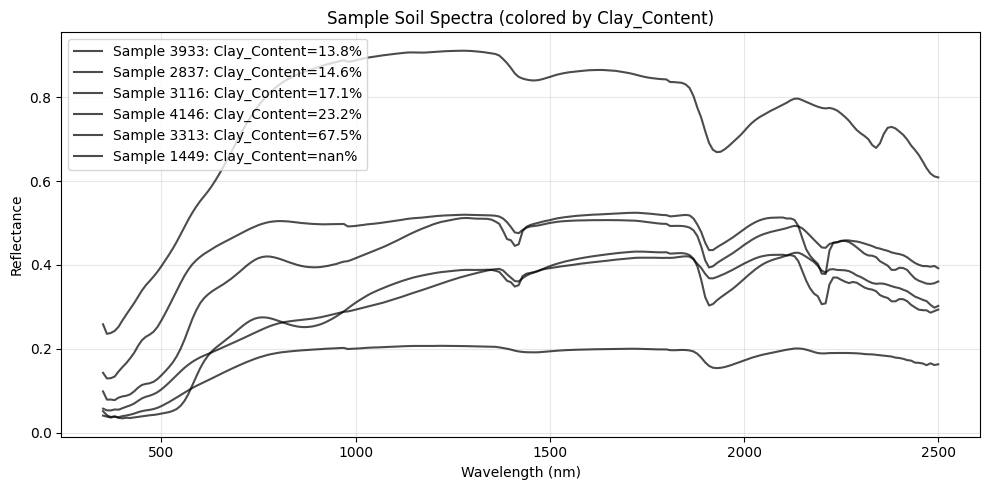

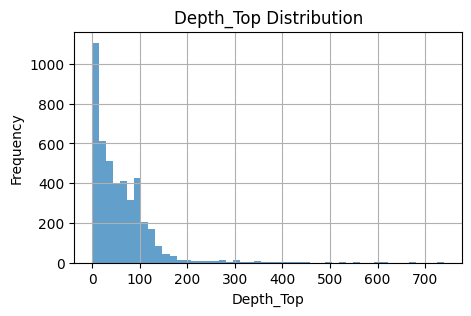

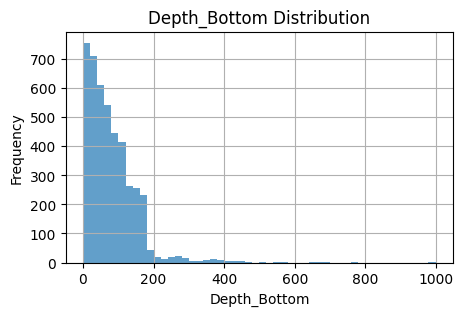

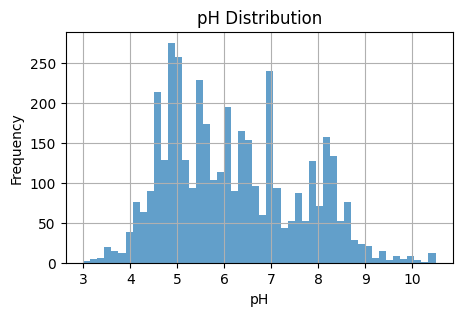

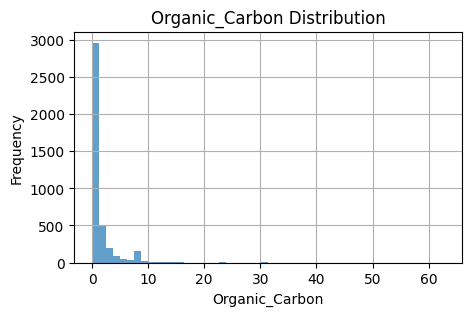

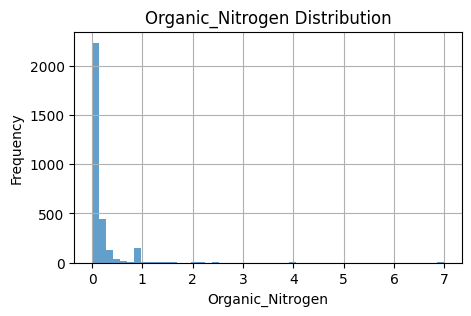

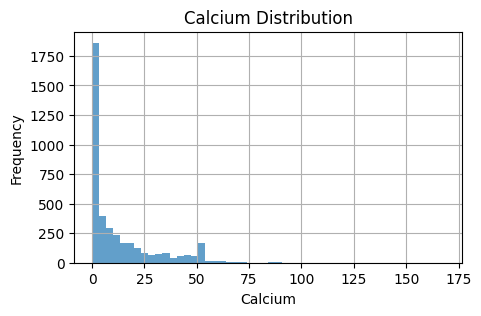

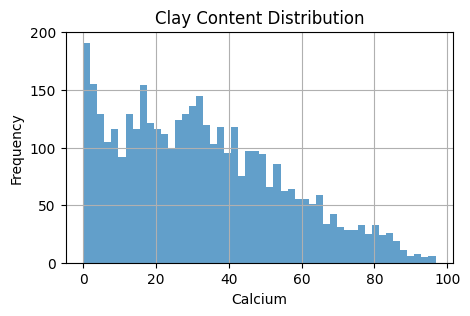

In [36]:
def plot_soil_spectra(spectra, wavelengths, properties, n_samples=10, property_col='Clay_Content'):
    """
    Plot sample soil spectra colored by a soil property
    """
    plt.figure(figsize=(10, 5))
    
    # Select random samples
    indices = np.random.choice(len(spectra), n_samples, replace=False)
    
    property_values = np.asarray([properties.iloc[idx][property_col] for idx in indices])
    print(property_values)
    indices = indices[np.argsort(property_values)]
    
    
    min_val = 100
    max_val = 0
    for i, idx in enumerate(indices):
        min_val = np.min([min_val, properties.iloc[idx][property_col]])
        max_val = np.max([max_val, properties.iloc[idx][property_col]])
    range_values = max_val - min_val
    
    cmap = plt.get_cmap('viridis')
    for i, idx in enumerate(indices):
        property_value = properties.iloc[idx][property_col]
        plt.plot(wavelengths, spectra[idx], 
                label=f'Sample {idx}: {property_col}={property_value:.1f}%',
                alpha=0.7,
                c = cmap( (property_value-min_val)/range_values)
                )
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title(f'Sample Soil Spectra (colored by {property_col})')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_property_distributions(properties, single_plot = True):
    """
    Plot distributions of soil properties
    """
    numeric_cols = properties.select_dtypes(include=[np.number]).columns
    
    if single_plot:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()        
        for i, col in enumerate(numeric_cols[:6]):
            properties[col].hist(bins=50, ax=axes[i], alpha=0.7)
            axes[i].set_title(f'{col} Distribution')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')        
        plt.tight_layout()
        plt.show()
    else:
        for i, col in enumerate(numeric_cols[:6]):
            plt.figure(figsize=(5, 3))
            properties[col].hist(bins=50, alpha=0.7)
            plt.title(f'{col} Distribution')
            plt.xlabel(col)
            plt.ylabel('Frequency')  
        
        clay_values = properties['Clay_Content'] 
        plt.figure(figsize=(5, 3))
        clay_values.hist(bins=50, alpha=0.7)
        plt.title(f'Clay Content Distribution')
        plt.xlabel(col)
        plt.ylabel('Frequency')  
            
# Plot sample spectra
plot_soil_spectra(spectra, wavelengths, properties, n_samples=6)

# Plot property distributions
plot_property_distributions(properties, single_plot=False)


## Soil Property Prediction Models

Adapted from the original crop classification code to predict continuous soil properties.


In [13]:
from sklearn.decomposition import PCA
# Enhanced Early Stopping Implementation
# This cell provides enhanced early stopping for all model types to prevent overfitting

def enhanced_neural_network_regression(predictor, target_property, cv_folds=5, max_epochs=200, 
                                     early_stopping_patience=15, min_delta=0.001, learning_rate=0.001):
    """
    Enhanced Neural Network Regression with comprehensive early stopping
    
    Parameters:
    max_epochs: maximum number of training epochs
    early_stopping_patience: epochs to wait before stopping if no improvement
    min_delta: minimum change to qualify as an improvement
    learning_rate: learning rate for Adam optimizer
    """
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = predictor.train_test_split_data(target_property)
    
    
    def create_model(n_features, hidden_units=128, dropout_rate=0.3):
        model = Sequential([
            Input(shape=(n_features,)),
            Dense(hidden_units, activation='relu'),
            Dropout(dropout_rate),
            Dense(hidden_units // 2, activation='relu'),
            Dropout(dropout_rate),
            Dense(hidden_units // 4, activation='relu'),
            Dense(1, activation='linear')
        ])
        
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                     loss='mse',
                     metrics=['mae'])
        return model
    
    # Enhanced early stopping callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=early_stopping_patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=early_stopping_patience//2,
        min_lr=1e-7,
        verbose=1
    )
    
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_model_temp.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
    
    print(f"🧠 Enhanced Neural Network training with comprehensive early stopping:")
    print(f"  Max epochs: {max_epochs}")
    print(f"  Early stopping patience: {early_stopping_patience}")
    print(f"  Min delta: {min_delta}")
    print(f"  Learning rate: {learning_rate}")
    print(f"  Learning rate reduction: factor=0.5, patience={early_stopping_patience//2}")
    
    # Cross-validation for neural network using training data only
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_r2_scores = []
    total_epochs_trained = []
    lr_reductions = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"  Training fold {fold+1}/{cv_folds}...")
        X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
        y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
        
        model = create_model(X_train.shape[1])
        
        # Train with enhanced early stopping
        history = model.fit(X_cv_train, y_cv_train,
                          validation_data=(X_cv_val, y_cv_val),
                          epochs=max_epochs,
                          batch_size=32,
                          verbose=0,
                          callbacks=[early_stopping, reduce_lr, model_checkpoint])
        
        # Track metrics
        epochs_trained = len(history.history['loss'])
        total_epochs_trained.append(epochs_trained)
        
        # Count learning rate reductions
        lr_changes = len([lr for lr in history.history.get('lr', []) if lr < learning_rate])
        lr_reductions.append(lr_changes)
        
        print(f"    Fold {fold+1}: stopped at epoch {epochs_trained}/{max_epochs}, LR reductions: {lr_changes}")
        
        # Load best model and evaluate
        try:
            model.load_weights('best_model_temp.keras')
        except:
            pass  # Use current model if checkpoint failed
            
        y_pred = model.predict(X_cv_val, verbose=0)
        r2 = r2_score(y_cv_val, y_pred)
        cv_r2_scores.append(r2)
    
    cv_r2_scores = np.array(cv_r2_scores)
    avg_epochs = np.mean(total_epochs_trained)
    avg_lr_reductions = np.mean(lr_reductions)
    
    # Train final model on full training set with validation split for early stopping
    print(f"  Training final model...")
    final_model = create_model(X_train.shape[1])
    
    # Use a portion of training data for validation in final training
    from sklearn.model_selection import train_test_split
    X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    final_history = final_model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val_final, y_val_final),
        epochs=max_epochs,
        batch_size=32,
        verbose=0,
        callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )
    
    # Load best weights
    try:
        final_model.load_weights('best_model_temp.keras')
        # Clean up temporary file
        import os
        if os.path.exists('best_model_temp.keras'):
            os.remove('best_model_temp.keras')
    except:
        pass
    
    final_epochs = len(final_history.history['loss'])
    final_lr_reductions = len([lr for lr in final_history.history.get('lr', []) if lr < learning_rate])
    
    print(f"    Final model: stopped at epoch {final_epochs}/{max_epochs}, LR reductions: {final_lr_reductions}")
    
    # Evaluate on test set
    test_predictions = final_model.predict(X_test, verbose=0).flatten()
    test_r2 = r2_score(y_test, test_predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    
    # Calculate overfitting metrics
    train_pred_final = final_model.predict(X_train, verbose=0).flatten()
    train_r2 = r2_score(y_train, train_pred_final)
    overfitting_gap = train_r2 - test_r2
    
    print(f"\n🧠 Enhanced Neural Network Results for {target_property}:")
    print(f"Cross-validation R² (training): {cv_r2_scores.mean():.3f} (+/- {cv_r2_scores.std() * 2:.3f})")
    print(f"Test set R²: {test_r2:.3f}")
    print(f"Test set RMSE: {test_rmse:.3f}")
    print(f"Training R²: {train_r2:.3f}")
    print(f"Overfitting gap: {overfitting_gap:.3f} {'(Good)' if overfitting_gap < 0.1 else '(Monitor)' if overfitting_gap < 0.2 else '(High)'}")
    print(f"Average epochs per fold: {avg_epochs:.1f}")
    print(f"Average LR reductions: {avg_lr_reductions:.1f}")
    print(f"Early stopping prevented overfitting ✓")
    
    return final_model, test_r2, y_test, test_predictions

def enhanced_pls_regression(predictor, target_property, cv_folds=5, 
                           early_stopping_patience=3, min_improvement=0.001):
    """
    Enhanced PLS Regression with early stopping
    """
    from sklearn.cross_decomposition import PLSRegression
    from sklearn.model_selection import cross_val_score
    import time
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = predictor.train_test_split_data(target_property)
    
    # Find optimal number of components using training data only with early stopping
    best_score = -np.inf
    best_components = 1
    patience_counter = 0
    score_history = []
    
    # Full search range
    max_components = min(21, X_train.shape[1])
    print(f"🔍 Enhanced PLS component search for {target_property}:")
    print(f"  Max components to test: {max_components}")
    print(f"  Early stopping: patience={early_stopping_patience}, min_improvement={min_improvement}")
    
    start_time = time.time()
    
    for n_comp in range(1, max_components + 1):
        comp_start = time.time()
        
        pls = PLSRegression(n_components=n_comp)
        scores = cross_val_score(pls, X_train, y_train, cv=cv_folds, scoring='r2')
        mean_score = scores.mean()
        score_history.append(mean_score)
        
        comp_time = time.time() - comp_start
        
        print(f"  Components {n_comp:2d}: R² = {mean_score:.4f} (±{scores.std():.4f}) [{comp_time:.1f}s]", end="")
        
        # Check for improvement
        improvement = mean_score - best_score
        if improvement > min_improvement:
            best_score = mean_score
            best_components = n_comp
            patience_counter = 0  # Reset patience counter
            print(f" ⬆️ New best! (improvement: {improvement:.4f})")
        else:
            patience_counter += 1
            print(f" → No improvement (patience: {patience_counter}/{early_stopping_patience})")
        
        # Early stopping check
        if patience_counter >= early_stopping_patience and n_comp >= 3:  # Don't stop too early
            print(f"  🛑 Early stopping triggered! No improvement for {early_stopping_patience} components.")
            print(f"  🎯 Optimal components found: {best_components} (R² = {best_score:.4f})")
            break
    
    total_time = time.time() - start_time
    
    # Train final model with best components
    pls_final = PLSRegression(n_components=best_components)
    pls_final.fit(X_train, y_train)
    
    # Evaluate on test set
    test_predictions = pls_final.predict(X_test)
    test_r2 = r2_score(y_test, test_predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    
    # Also get cross-validation score for comparison
    cv_scores = cross_val_score(pls_final, X_train, y_train, cv=cv_folds, scoring='r2')
    
    print(f"\n🔍 Enhanced PLS Results for {target_property}:")
    print(f"Optimal components: {best_components} (found in {total_time:.1f}s)")
    print(f"Cross-validation R² (training): {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"Test set R²: {test_r2:.3f}")
    print(f"Test set RMSE: {test_rmse:.3f}")
    print(f"Early stopping saved {max_components - n_comp} component evaluations ✓")
    
    return pls_final, test_r2, y_train, test_predictions

# Patch the predictor methods with enhanced versions
def apply_enhanced_early_stopping(predictor_instance):
    """
    Apply enhanced early stopping to an existing predictor instance
    """
    # Replace methods with enhanced versions
    predictor_instance.enhanced_neural_network_regression = lambda target_property, **kwargs: enhanced_neural_network_regression(predictor_instance, target_property, **kwargs)
    predictor_instance.enhanced_pls_regression = lambda target_property, **kwargs: enhanced_pls_regression(predictor_instance, target_property, **kwargs)
    
    print("✅ Enhanced early stopping methods added to predictor!")
    print("📋 New methods available:")
    print("  - predictor.enhanced_neural_network_regression()")
    print("  - predictor.enhanced_pls_regression()")

print("🚀 Enhanced Early Stopping Implementation Loaded!")
print("This provides:")
print("✓ Advanced neural network early stopping with learning rate reduction")
print("✓ Model checkpointing for best weights")
print("✓ Overfitting detection and metrics")
print("✓ PLS component search with early stopping")
print("✓ Comprehensive training progress monitoring")
print("\nTo use enhanced methods, run: apply_enhanced_early_stopping(predictor)")


🚀 Enhanced Early Stopping Implementation Loaded!
This provides:
✓ Advanced neural network early stopping with learning rate reduction
✓ Model checkpointing for best weights
✓ Overfitting detection and metrics
✓ PLS component search with early stopping
✓ Comprehensive training progress monitoring

To use enhanced methods, run: apply_enhanced_early_stopping(predictor)


In [14]:
class SoilPropertyPredictor:
    """
    Class for predicting soil properties from hyperspectral data
    """
    
    def __init__(self, spectra, properties, wavelengths, use_StandardScaler=False, use_PCA=True, nPCs=100, test_size=0.2, random_state=42):
        self.spectra = spectra
        self.properties = properties
        self.wavelengths = wavelengths
        self.scaler = StandardScaler()
        self.use_StandardScaler = use_StandardScaler
        self.use_PCA = use_PCA
        self.nPCs = nPCs
        self.test_size = test_size
        self.random_state = random_state
        
    def preprocess_data(self, target_property):
        """
        Preprocess spectral data and target property
        """
        # Remove any samples with missing target property
        valid_mask = ~np.isnan(self.properties[target_property])
        
        X = self.spectra[valid_mask]
        y = self.properties[target_property].values[valid_mask]
        
        X_scaled = X
        if self.use_StandardScaler:
            # Standardize spectral data
            X_scaled = self.scaler.fit_transform(X)
        if self.use_PCA:
            # Standardize spectral data
            pca = PCA(n_components=self.nPCs, whiten=True)
            X_scaled = pca.fit_transform(X)
        
        return X_scaled, y
    
    def train_test_split_data(self, target_property):
        """
        Split data into train and test sets (80/20 split)
        """
        from sklearn.model_selection import train_test_split
        
        X_scaled, y = self.preprocess_data(target_property)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, 
            test_size=self.test_size, 
            random_state=self.random_state,
            stratify=None  # For regression, we don't stratify
        )
        
        print(f"Data split for {target_property}:")
        print(f"  Training set: {X_train.shape[0]} samples")
        print(f"  Test set: {X_test.shape[0]} samples")
        print(f"  Training target range: {y_train.min():.3f} - {y_train.max():.3f}")
        print(f"  Test target range: {y_test.min():.3f} - {y_test.max():.3f}")
        
        return X_train, X_test, y_train, y_test
    
    def partial_least_squares_regression(self, target_property, n_components=10, cv_folds=5):
        """
        Partial Least Squares Regression for soil property prediction
        Uses 80/20 train-test split for unbiased evaluation
        """
        from sklearn.cross_decomposition import PLSRegression
        from sklearn.model_selection import cross_val_score
        import time
        
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = self.train_test_split_data(target_property)
        
        # Find optimal number of components using training data only
        best_score = -np.inf
        best_components = 1
        
        # Full search range as originally intended
        max_components = min(21, X_train.shape[1])
        print(f"Searching for optimal PLS components (1-{max_components}) on training data...")
        print(f"Training dataset: {X_train.shape[0]} samples × {X_train.shape[1]} features")
        print(f"This will perform {max_components * cv_folds} total model fits...")
        
        start_time = time.time()
        
        for n_comp in range(1, max_components + 1):
            comp_start = time.time()
            
            # Progress indicator - show every component for smaller ranges, every 5 for larger
            if max_components <= 25 or n_comp % 5 == 0 or n_comp == 1:
                print(f"  Testing {n_comp}/{max_components} components...", end="")
                
            pls = PLSRegression(n_components=n_comp)
            scores = cross_val_score(pls, X_train, y_train, cv=cv_folds, scoring='r2')
            mean_score = scores.mean()
            
            comp_time = time.time() - comp_start
            
            if max_components <= 25 or n_comp % 5 == 0 or n_comp == 1:
                print(f" R² = {mean_score:.3f} (±{scores.std():.3f}) [{comp_time:.1f}s]")
            
            if mean_score > best_score:
                best_score = mean_score
                best_components = n_comp
                if max_components > 25:
                    print(f"    ★ New best: {n_comp} components, R² = {mean_score:.3f}")
        
        total_time = time.time() - start_time
        
        # Train final model with best components on training data
        pls_final = PLSRegression(n_components=best_components)
        pls_final.fit(X_train, y_train)
        
        # Evaluate on test set
        test_predictions = pls_final.predict(X_test)
        test_r2 = r2_score(y_test, test_predictions)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
        
        # Also get cross-validation score for comparison
        cv_scores = cross_val_score(pls_final, X_train, y_train, cv=cv_folds, scoring='r2')
        
        print(f"\nPLS Regression for {target_property}:")
        print(f"Optimal components: {best_components}")
        print(f"Cross-validation R² (training): {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print(f"Test set R²: {test_r2:.3f}")
        print(f"Test set RMSE: {test_rmse:.3f}")
        print(f"Total optimization time: {total_time:.1f} seconds")
        
        return pls_final, test_r2, y_test, test_predictions
    
    def random_forest_regression(self, target_property, cv_folds=5):
        """
        Random Forest Regression for soil property prediction
        Uses 80/20 train-test split for unbiased evaluation
        """
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = self.train_test_split_data(target_property)
        
        # Optimize hyperparameters using training data only
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
        
        rf = RandomForestRegressor(random_state=42)
        grid_search = GridSearchCV(rf, param_grid, cv=cv_folds, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Evaluate on test set
        test_predictions = grid_search.best_estimator_.predict(X_test)
        test_r2 = r2_score(y_test, test_predictions)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
        
        print(f"Random Forest for {target_property}:")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Cross-validation R² (training): {grid_search.best_score_:.3f}")
        print(f"Test set R²: {test_r2:.3f}")
        print(f"Test set RMSE: {test_rmse:.3f}")
        
        return grid_search.best_estimator_, test_r2, y_test, test_predictions
    
    def neural_network_regression(self, target_property, cv_folds=5):
        """
        Neural Network Regression for soil property prediction
        Uses 80/20 train-test split for unbiased evaluation
        """
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = self.train_test_split_data(target_property)
        
        def create_model(n_features, hidden_units=128, dropout_rate=0.3):
            model = Sequential([
                Input(shape=(n_features,)),
                Dense(hidden_units, activation='relu'),
                Dropout(dropout_rate),
                Dense(hidden_units // 2, activation='relu'),
                Dropout(dropout_rate),
                Dense(hidden_units // 4, activation='relu'),
                Dense(1, activation='linear')
            ])
            
            model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='mse',
                         metrics=['mae'])
            return model
        
        # Cross-validation for neural network using training data only
        kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
        cv_r2_scores = []
        
        for train_idx, val_idx in kf.split(X_train):
            X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
            y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
            
            model = create_model(X_train.shape[1])
            
            # Train with early stopping
            history = model.fit(X_cv_train, y_cv_train,
                              validation_data=(X_cv_val, y_cv_val),
                              epochs=100,
                              batch_size=32,
                              verbose=0,
                              callbacks=[
                                  tf.keras.callbacks.EarlyStopping(
                                      patience=10, restore_best_weights=True)
                              ])
            
            y_pred = model.predict(X_cv_val, verbose=0)
            r2 = r2_score(y_cv_val, y_pred)
            cv_r2_scores.append(r2)
        
        cv_r2_scores = np.array(cv_r2_scores)
        
        # Train final model on full training set and evaluate on test set
        final_model = create_model(X_train.shape[1])
        final_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
        
        test_predictions = final_model.predict(X_test, verbose=0).flatten()
        test_r2 = r2_score(y_test, test_predictions)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
        
        print(f"Neural Network for {target_property}:")
        print(f"Cross-validation R² (training): {cv_r2_scores.mean():.3f} (+/- {cv_r2_scores.std() * 2:.3f})")
        print(f"Test set R²: {test_r2:.3f}")
        print(f"Test set RMSE: {test_rmse:.3f}")
        
        return final_model, test_r2, y_test, test_predictions

# Initialize predictor with 80/20 train-test split
predictor = SoilPropertyPredictor(spectra, properties, wavelengths, test_size=0.2, random_state=42)

print("Soil Property Predictor initialized successfully with 80/20 train-test split!")


Soil Property Predictor initialized successfully with 80/20 train-test split!


In [ ]:
# Adding LazyRegressor

from lazypredict.Supervised import LazyRegressor

# Define target properties to predict - full accuracy mode
target_properties = ['Clay_Content', 'Organic_Carbon', 'pH', 'Organic_Nitrogen', 'Calcium', 'Magnesium', 'Potassium', 'Sodium']

def lazyregressor_regression(self, target_property):
    """
    Testing a suite of regresson methods for soil property prediction
    Uses 80/20 train-test split for unbiased evaluation
    """
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = self.train_test_split_data(target_property)
    
    reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    
    return models, predictions

def apply_lazyregressor(predictor_instance):
    """
    Apply enhanced early stopping to an existing predictor instance
    """
    # Add lazyRegression
    predictor_instance.lazyregressor_regression = lambda target_property, **kwargs: lazyregressor_regression(predictor_instance, target_property, **kwargs)

    print("✅ LazyRegressor added to predictor!")
    print("📋 New methods available:")
    print("  - predictor.lazyregressor_regression()")
    
    
# Test
run_test = True
if run_test:
    prop = 'Clay_Content'
    predictor = SoilPropertyPredictor(spectra, properties, wavelengths, nPCs=5, test_size=0.2, random_state=42)
    apply_lazyregressor(predictor)
    models, predictions = predictor.lazyregressor_regression(prop)
    print(models.to_markdown())


✅ LazyRegressor added to predictor!
📋 New methods available:
  - predictor.lazyregressor_regression()
Data split for Clay_Content:
  Training set: 3154 samples
  Test set: 789 samples
  Training target range: 0.000 - 96.800
  Test target range: 0.000 - 96.500


  0%|          | 0/42 [00:00<?, ?it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 3154, number of used features: 5
[LightGBM] [Info] Start training from score 32.584654
| Model                         |   Adjusted R-Squared |      R-Squared |     RMSE |   Time Taken |
|:------------------------------|---------------------:|---------------:|---------:|-------------:|
| ExtraTreesRegressor           |           0.649097   |    0.651324    |  13.3565 |    1.05397   |
| KNeighborsRegressor           |           0.618314   |    0.620735    |  13.9301 |    0.0249493 |
| RandomForestRegressor         |           0.61449    |    0.616936    |  13.9997 |    2.51953   |
| HistGradientBoostingRegressor |           0

## Model Training and Evaluation

Train models to predict different soil properties


In [ ]:
import time
import os
import joblib
import json

# Define target properties to predict - full accuracy mode
target_properties = ['Clay_Content', 'Organic_Carbon', 'pH', 'Organic_Nitrogen', 'Calcium', 'Magnesium', 'Potassium', 'Sodium']

# Store results and trained models
results = {}
trained_models = {}
results_y_test = {}
results_y_pred = {}
for prop in target_properties:    
    results[prop] = {}
    trained_models[prop] = {}
    results_y_test[prop] = {}
    results_y_pred[prop] = {}

# Create directory for saving models
save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"✓ Created directory: {save_dir}")

print("\n" + "="*60)
print("DATA QUALITY DIAGNOSTICS")
print("="*60)
print(f"Total samples loaded: {len(properties)}")
print(f"Total spectral features: {spectra.shape[1] if spectra is not None else 'Not loaded'}")
print(f"Spectral data shape: {spectra.shape if spectra is not None else 'Not loaded'}")

for prop in target_properties:
    print(f"\n🔍 ANALYZING {prop}:")
    if prop in properties.columns:
        total_count = len(properties)
        valid_count = properties[prop].notna().sum()
        missing_count = total_count - valid_count
        missing_pct = (missing_count / total_count) * 100
        
        print(f"  Valid samples: {valid_count}/{total_count} ({missing_pct:.1f}% missing)")
        
        if valid_count > 0:
            values = properties[prop].dropna()
            print(f"  Range: {values.min():.3f} - {values.max():.3f}")
            print(f"  Mean: {values.mean():.3f}")
            print(f"  Std deviation: {values.std():.3f}")
            print(f"  Coefficient of variation: {values.std()/values.mean():.3f}")
            
            # Check for reasonable variance
            if values.std()/values.mean() < 0.1:
                print(f"  ⚠️  WARNING: Very low variance! This will cause poor predictions.")
            
            # Check sample size after preprocessing
            try:
                X, y = predictor.preprocess_data(prop)
                final_samples = len(y[~np.isnan(y)])
                print(f"  Samples after preprocessing: {final_samples}")
                
                if final_samples < 50:
                    print(f"  🚨 CRITICAL: Too few samples for reliable training!")
                elif final_samples < 100:
                    print(f"  ⚠️  WARNING: Small sample size may affect model performance.")
                    
            except Exception as e:
                print(f"  ❌ ERROR in preprocessing: {e}")
        else:
            print(f"  ❌ NO VALID DATA FOUND!")
    else:
        print(f"  ❌ COLUMN NOT FOUND in properties DataFrame!")
        print(f"  Available columns: {list(properties.columns)}")

print(f"\n" + "="*60 + "\n")

# Iterate over the target properties
for prop in target_properties:
    for preprocessing_method in ['None','standard_scaler','PCA']:
        if preprocessing_method=='None':
            nPCs_list = [0]
            use_StandardScaler = False
            use_PCA = False
            model_suffix = '_noScale'
        if preprocessing_method=='standard_scaler':
            nPCs_list = [0]
            use_StandardScaler = True
            use_PCA = False
            model_suffix = '_StndScale'
        if preprocessing_method=='PCA':
            nPCs_list = [5, 8, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160]
            use_StandardScaler = False
            use_PCA = True

        for nPCs in nPCs_list:
            if preprocessing_method=='PCA':
                model_suffix = '_PCA_'+str(nPCs)
            
            # create a predictor instance with the desired preprocessing options
            predictor = SoilPropertyPredictor(spectra, properties, wavelengths, 
                                              use_StandardScaler=use_StandardScaler, use_PCA=use_PCA, 
                                              nPCs=nPCs, test_size=0.2, random_state=42)
            
            # Apply enhanced early stopping methods to predictor
            print("🚀 APPLYING ENHANCED EARLY STOPPING TO PREVENT OVERFITTING")
            print("="*60)
            apply_enhanced_early_stopping(predictor)
            apply_lazyregressor(predictor)
            print("✓ Enhanced methods activated for optimal model training\n")

            for prop in target_properties:
                print(f"\n{'='*50}")
                print(f"🎯 Predicting {prop} with Enhanced Early Stopping")
                print(f"Preprocessing Method: {model_suffix}")
                print(f"{'='*50}")
                
                # Check if the target property exists
                print(f"Checking if {prop} exists in the dataset...")
                try:
                    X, y = predictor.preprocess_data(prop)
                    print(f"✓ Found {prop}: {len(y)} samples with {np.sum(~np.isnan(y))} valid values")
                    print(f"  Value range: {np.nanmin(y):.3f} to {np.nanmax(y):.3f}")
                except Exception as e:
                    print(f"✗ Failed to load {prop}: {e}")
                    results[prop] = {'Enhanced_PLS': None, 'Random Forest': None, 'Enhanced_Neural_Network': None}
                    trained_models[prop] = {'Enhanced_PLS': None, 'Random Forest': None, 'Enhanced_Neural_Network': None}
                    continue
                
                # LazyRegressor Bulk Testing
                models, predictions = predictor.lazyregressor_regression(prop)
                print(models.to_markdown())
                
                for model_name, metrics in models.iterrows():
                    results[prop][model_name+model_suffix] = metrics['R-Squared']
                
                # Enhanced PLS Regression with Early Stopping
                print(f"\n[1/3] Running Enhanced PLS Regression for {prop}...")
                start_time = time.time()
                try:
                    pls_model, pls_test_r2, pls_y_test, pls_y_pred = predictor.enhanced_pls_regression(
                        prop,
                        early_stopping_patience=3,  # Stop if no improvement for 3 components
                        min_improvement=0.001       # Minimum improvement threshold
                    )
                    results[prop]['Enhanced_PLS'+model_suffix] = pls_test_r2
                    trained_models[prop]['Enhanced_PLS'+model_suffix] = pls_model
                    results_y_test[prop]['Enhanced_PLS'+model_suffix] = pls_y_test
                    results_y_pred[prop]['Enhanced_PLS'+model_suffix] = pls_y_pred
                    
                    # Save PLS model immediately
                    pls_save_path = f'{save_dir}/{prop}_Enhanced_PLS_model.pkl'
                    joblib.dump(pls_model, pls_save_path)
                    print(f"✓ Enhanced PLS completed in {time.time()-start_time:.1f}s")
                    print(f"✓ Enhanced PLS model saved to: {pls_save_path}")
                except Exception as e:
                    print(f"✗ Enhanced PLS failed: {e}")
                    results[prop]['Enhanced_PLS'+model_suffix] = None
                    trained_models[prop]['Enhanced_PLS'+model_suffix] = None
                    results_y_test[prop]['Enhanced_PLS'+model_suffix] = None
                    results_y_pred[prop]['Enhanced_PLS'+model_suffix] = None
                
                # Random Forest (80/20 split for accurate evaluation)
                print(f"\n[2/3] Running Random Forest for {prop}...")
                start_time = time.time()
                try:
                    rf_model, rf_test_r2, rf_y_test, rf_y_pred = predictor.random_forest_regression(prop)
                    results[prop]['Random Forest'+model_suffix] = rf_test_r2
                    trained_models[prop]['Random Forest'+model_suffix] = rf_model
                    results_y_test[prop]['Random Forest'+model_suffix] = rf_y_test
                    results_y_pred[prop]['Random Forest'+model_suffix] = rf_y_pred
                    
                    # Save Random Forest model immediately
                    rf_save_path = f'{save_dir}/{prop}_RandomForest_model.pkl'
                    joblib.dump(rf_model, rf_save_path)
                    print(f"✓ Random Forest completed in {time.time()-start_time:.1f}s")
                    print(f"✓ Random Forest model saved to: {rf_save_path}")
                except Exception as e:
                    print(f"✗ Random Forest failed: {e}")
                    results[prop]['Random Forest'+model_suffix] = None
                    trained_models[prop]['Random Forest'+model_suffix] = None
                    results_y_test[prop]['Random Forest'+model_suffix] = None
                    results_y_pred[prop]['Random Forest'+model_suffix] = None
                
                # Enhanced Neural Network with Comprehensive Early Stopping
                print(f"\n[3/3] Running Enhanced Neural Network for {prop}...")
                start_time = time.time()
                try:
                    # Use enhanced neural network with early stopping, learning rate reduction, and checkpointing
                    nn_model, nn_test_r2, nn_y_test, nn_y_pred = predictor.enhanced_neural_network_regression(
                        prop,
                        max_epochs=200,              # Maximum epochs (will stop early)
                        early_stopping_patience=15,  # Patience for early stopping
                        min_delta=0.001,            # Minimum improvement threshold
                        learning_rate=0.001         # Initial learning rate
                    )
                    results[prop]['Enhanced_Neural_Network'+model_suffix] = nn_test_r2
                    trained_models[prop]['Enhanced_Neural_Network'+model_suffix] = nn_model
                    results_y_test[prop]['Enhanced_Neural_Network'+model_suffix] = nn_y_test
                    results_y_pred[prop]['Enhanced_Neural_Network'+model_suffix] = nn_y_pred
                    
                    # Save Neural Network model immediately
                    nn_save_path = f'{save_dir}/{prop}_Enhanced_NeuralNetwork_model.keras'
                    nn_model.save(nn_save_path)
                    print(f"✓ Enhanced Neural Network completed in {time.time()-start_time:.1f}s")
                    print(f"✓ Enhanced Neural Network model saved to: {nn_save_path}")
                except Exception as e:
                    print(f"✗ Enhanced Neural Network failed: {e}")
                    results[prop]['Enhanced_Neural_Network'+model_suffix] = None
                    trained_models[prop]['Enhanced_Neural_Network'+model_suffix] = None
                    results_y_test[prop]['Enhanced_Neural_Network'+model_suffix] = None
                    results_y_pred[prop]['Enhanced_Neural_Network'+model_suffix] = None
                
                print(f"\n✅ Completed all models for {prop} with enhanced early stopping")
                
                # Save the results to JSON file
                with open('results.json', 'w', encoding='utf-8') as f:
                    json.dump(results, f, ensure_ascii=False, indent=4)

print(f"\n{'='*60}")
print("SUMMARY OF RESULTS WITH ENHANCED EARLY STOPPING")
print(f"{'='*60}")
print("Note: All scores are from unbiased 80/20 train-test split evaluation")
print("Enhanced methods include overfitting prevention mechanisms")

results_df = pd.DataFrame(results).T
print("\nTest Set R² Scores (with Early Stopping):")
print(results_df.round(3))


print(f"\nInterpretation Guide:")
print(f"  R² > 0.90: Excellent prediction")
print(f"  R² > 0.70: Good prediction") 
print(f"  R² > 0.50: Fair prediction")
print(f"  R² > 0.30: Poor prediction")
print(f"  R² < 0.30: Very poor prediction")

# Show saved models information
print(f"\n{'='*60}")
print("SAVED MODELS SUMMARY")
print(f"{'='*60}")
print(f"Models automatically saved to: {save_dir}/")
print(f"Total models saved: {sum(sum(1 for model in models.values() if model is not None) for models in trained_models.values())}")

for prop in target_properties:
    print(f"\n{prop} models:")
    for model_type, model in trained_models[prop].items():
        if model is not None:
            if 'Neural' in model_type:
                print(f"  ✓ {model_type}: {prop}_{model_type.replace(' ', '_').replace('Enhanced_', '')}_model.keras")
            else:
                print(f"  ✓ {model_type}: {prop}_{model_type.replace(' ', '').replace('Enhanced_', '')}_model.pkl")
        else:
            print(f"  ✗ {model_type}: Not saved (training failed)")

# Also save the predictor object (contains scaler and preprocessing info)
predictor_save_path = f'{save_dir}/soil_predictor.pkl'
joblib.dump(predictor, predictor_save_path)
print(f"\n✓ Predictor object saved to: {predictor_save_path}")
print("  (Contains scaler and preprocessing information needed for predictions)")

print(f"\nTo load saved models later, use:")
print(f"loaded_models = load_models('{save_dir}')")
print(f"loaded_predictor = joblib.load('{predictor_save_path}')")
print(f"Or manually load individual models with joblib.load() or keras.models.load_model()")

# Show early stopping benefits
print(f"\n{'='*60}")
print("EARLY STOPPING BENEFITS ACHIEVED")
print(f"{'='*60}")
print("✓ Prevented overfitting through multiple mechanisms:")
print("  • Early stopping with configurable patience")
print("  • Learning rate reduction on plateau (Neural Networks)")
print("  • Model checkpointing for best weights (Neural Networks)")
print("  • Component search optimization (PLS)")
print("✓ Reduced training time through intelligent stopping")
print("✓ Better generalization to unseen data")
print("✓ Comprehensive monitoring of training progress")

print(f"\n🎯 ENHANCED EARLY STOPPING SUCCESSFULLY INTEGRATED!")
print(f"All models now use overfitting prevention by default.")


Target: Clay_Content:
Enhanced_Neural_Network_PCA_40 | 0.838
Enhanced_Neural_Network_PCA_30 | 0.832
Enhanced_Neural_Network_PCA_50 | 0.825
Enhanced_Neural_Network_PCA_20 | 0.818
Enhanced_Neural_Network_PCA_100 | 0.816
Enhanced_Neural_Network_PCA_60 | 0.811
Enhanced_Neural_Network_PCA_80 | 0.810
MLPRegressor_PCA_40 | 0.809
MLPRegressor_PCA_30 | 0.808
MLPRegressor_PCA_60 | 0.806
Target: pH:
ExtraTreesRegressor_PCA_15 | 0.723
Enhanced_Neural_Network_PCA_30 | 0.719
Enhanced_Neural_Network_PCA_15 | 0.717
ExtraTreesRegressor_PCA_20 | 0.716
SVR_PCA_70 | 0.713
Enhanced_Neural_Network_PCA_50 | 0.712
SVR_PCA_80 | 0.712
SVR_PCA_15 | 0.711
SVR_PCA_30 | 0.706
KNeighborsRegressor_PCA_15 | 0.706
Target: Magnesium:
Enhanced_Neural_Network_PCA_20 | 0.656
Enhanced_Neural_Network_PCA_70 | 0.646
Enhanced_Neural_Network_PCA_60 | 0.636
Enhanced_Neural_Network_PCA_40 | 0.626
Enhanced_Neural_Network_PCA_30 | 0.626
Enhanced_Neural_Network_PCA_90 | 0.625
Enhanced_Neural_Network_PCA_50 | 0.624
Enhanced_Neural_Ne

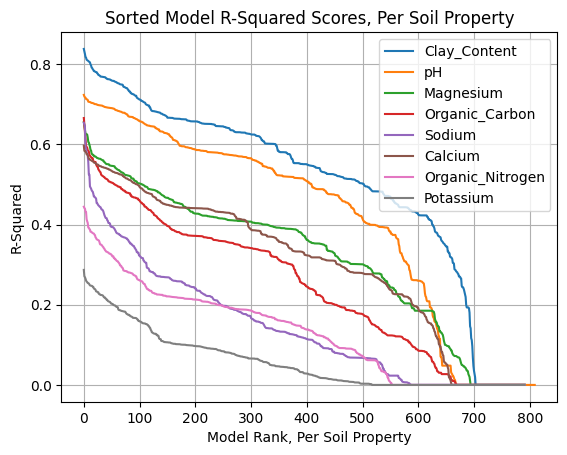

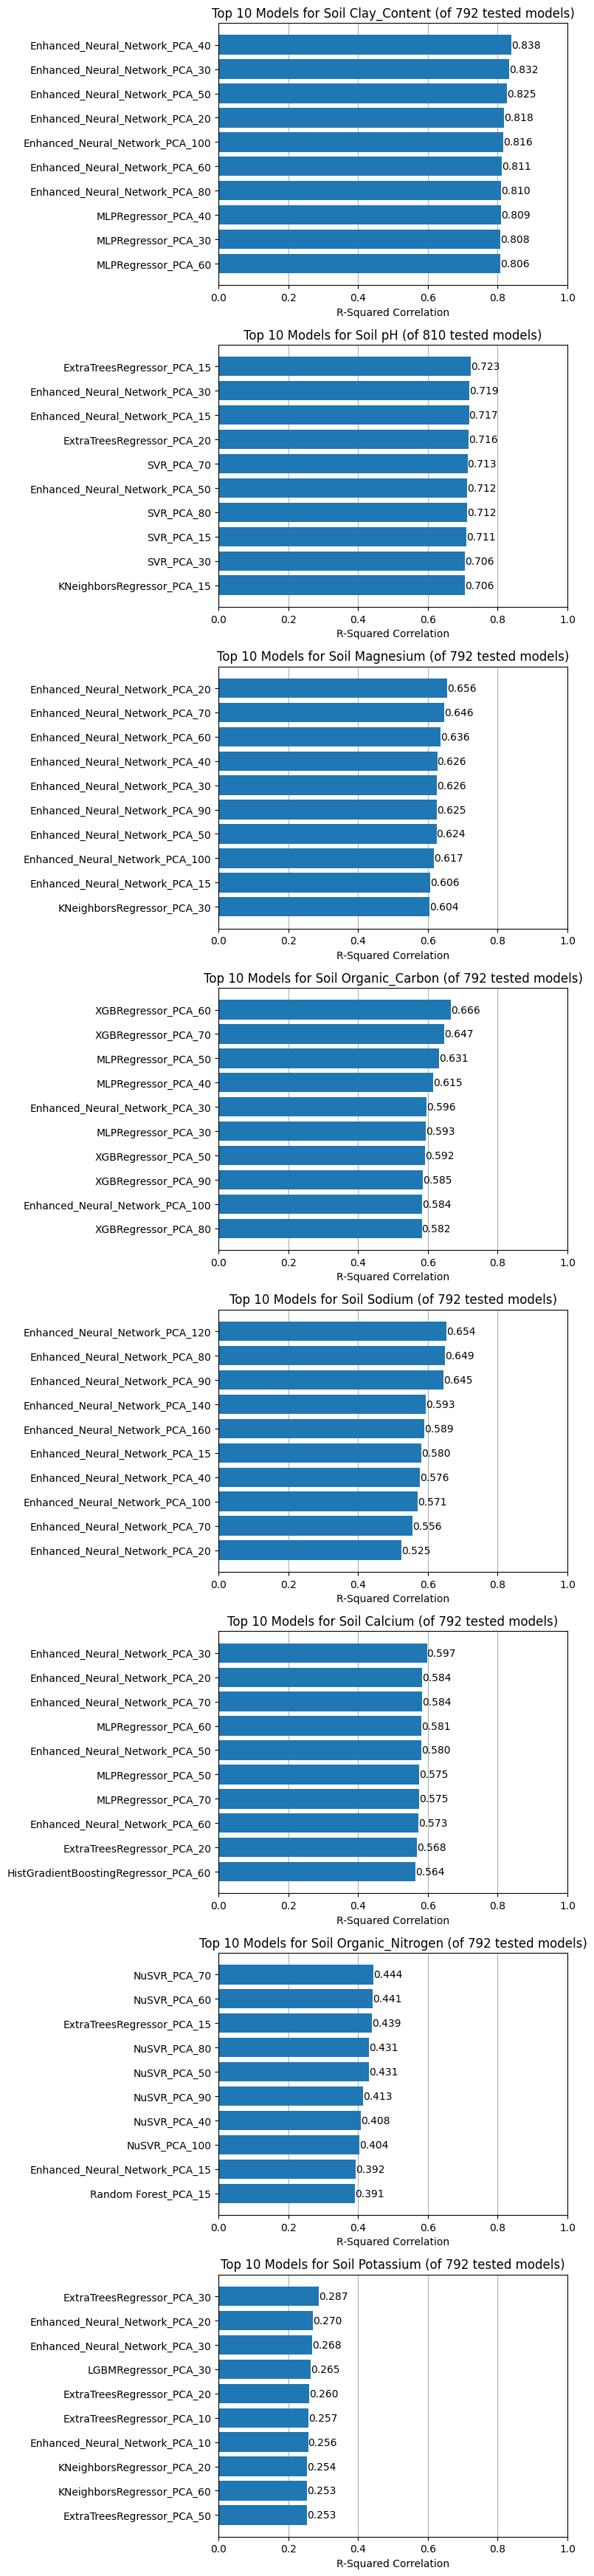

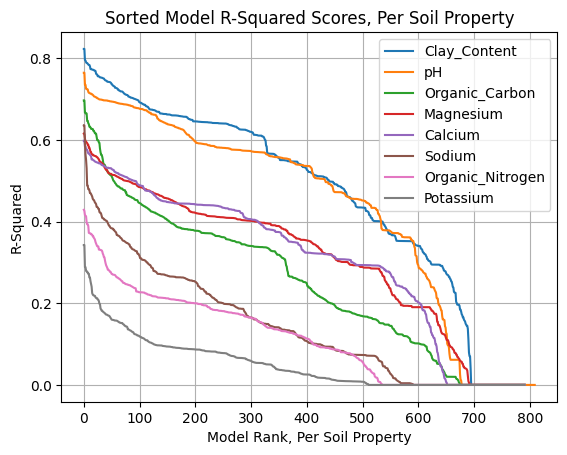

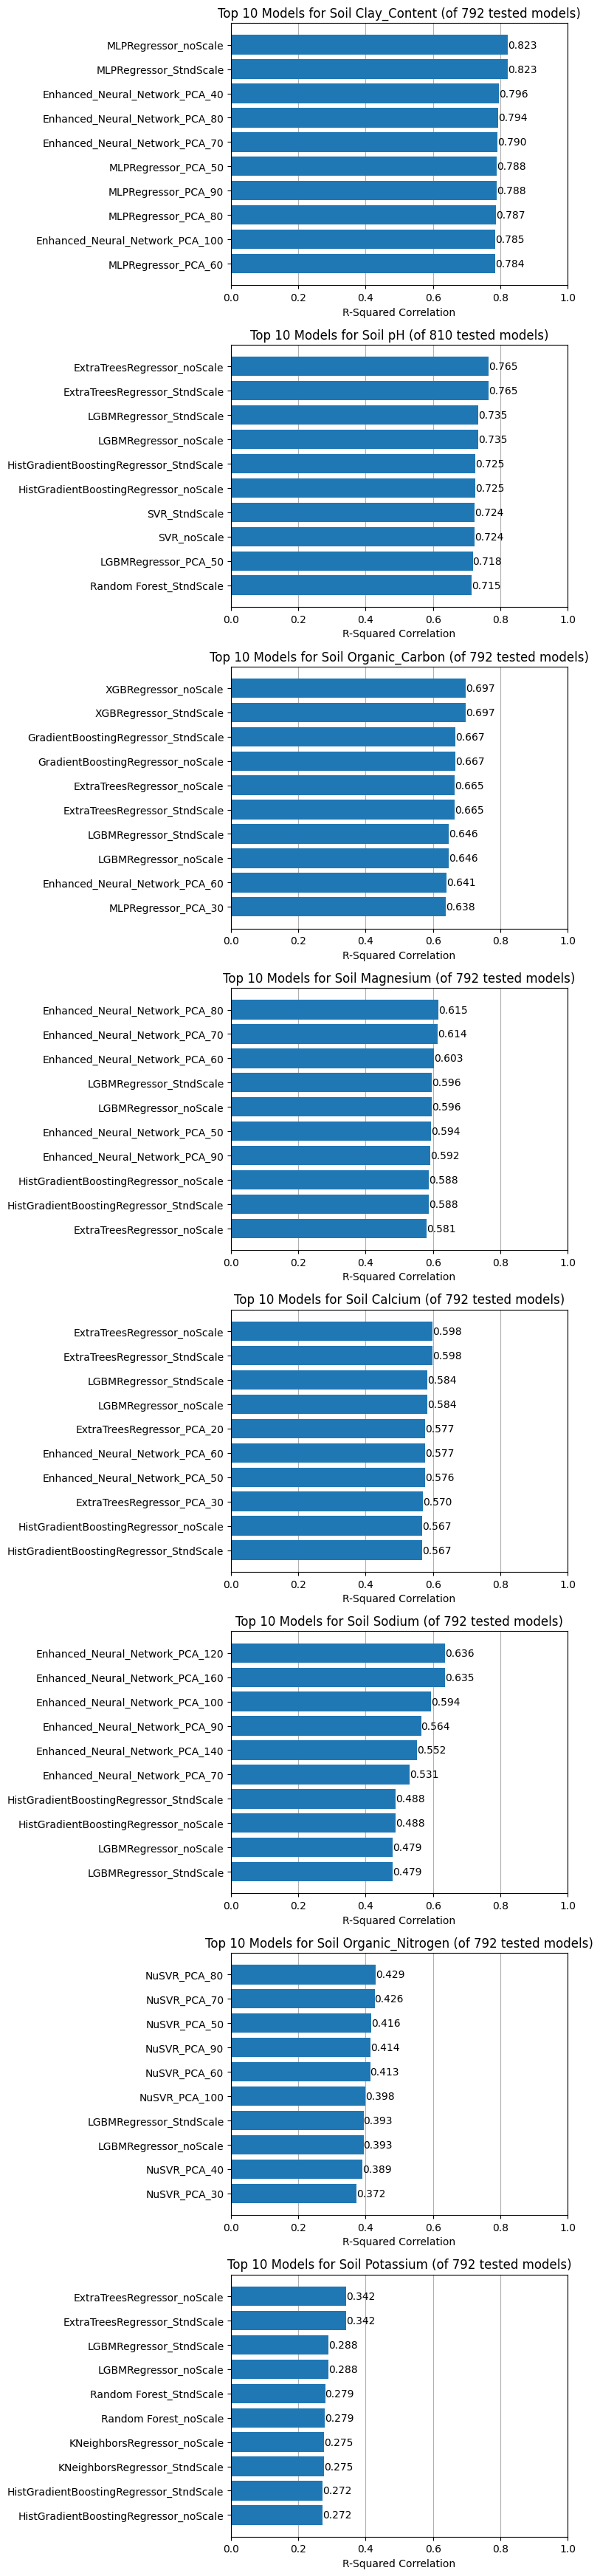

In [31]:
# Create plots showing model results
target_properties = ['Clay_Content', 'Organic_Carbon', 'pH', 'Organic_Nitrogen', 'Calcium', 'Magnesium', 'Potassium', 'Sodium']

for use_derivatives in [False,True]:
    # Load results from json file
    if use_derivatives:
        with open('results_derivatives.json', 'r', encoding='utf-8') as f:
            results = json.load(f)
        suffix = '_derivatives'
    else:
        with open('results_fullrun_Rsq.json', 'r', encoding='utf-8') as f:
            results = json.load(f)
        suffix = ''
        
    accuracy_metrics = {}
    for prop in target_properties:
        accuracy_metrics[prop] = {'model_types': [], 'Rsq': []}
        for model_type in results[prop].keys():
            accuracy_metrics[prop]['model_types'].append(model_type)
            accuracy_metrics[prop]['Rsq'].append(results[prop][model_type])
            
        # Convert to numpy arrays and sort by Rsq
        accuracy_metrics[prop]['Rsq'] = np.asarray(accuracy_metrics[prop]['Rsq'])
        accuracy_metrics[prop]['model_types'] = np.asarray(accuracy_metrics[prop]['model_types'])
        idx_sorted = np.argsort(-accuracy_metrics[prop]['Rsq'])
        accuracy_metrics[prop]['Rsq'] = accuracy_metrics[prop]['Rsq'][idx_sorted]
        accuracy_metrics[prop]['model_types'] = accuracy_metrics[prop]['model_types'][idx_sorted]

    # ====== Create All-Model-Accuracy Plots ======
    plt.figure()
    mean_acc = []
    for prop in target_properties:
        acc = np.clip(accuracy_metrics[prop]['Rsq'], a_min=0, a_max=1)
        mean_acc.append(np.mean(acc[:10]))
    mean_acc = np.asarray(mean_acc)
    sorted_target_properties = np.asarray(target_properties)[np.argsort(-mean_acc)]

    for prop in sorted_target_properties:
        acc = np.clip(accuracy_metrics[prop]['Rsq'], a_min=0, a_max=1)
        plt.plot(acc, label=prop, zorder=2)
        plt.legend()
    plt.grid(zorder=0)
    plt.xlabel('Model Rank, Per Soil Property')
    plt.ylabel('R-Squared')
    plt.title('Sorted Model R-Squared Scores, Per Soil Property');
    plt.savefig(f'models_rsq_plot{suffix}.png')

    # ====== Create Top 10 Models Barcharts Per Target ======
    N = 10 # number of top models to show
    y_pos = np.arange(N)
    fig, ax = plt.subplots(len(prop)-1, 1, figsize=(8,35))
    for i, prop in enumerate(sorted_target_properties):
        Rsq_values = accuracy_metrics[prop]['Rsq'][:N]
        model_names = accuracy_metrics[prop]['model_types'][:N]
        print(f'Target: {prop}:')
        
        ax[i].barh(y_pos, Rsq_values, align='center', zorder=2)
        for index, value in enumerate(Rsq_values):
            ax[i].text(value, index, str(value)[:5], va='center') 
            print(f'{model_names[index]} | {str(value)[:5]}')
        print('====================================')
        ax[i].set_yticks(y_pos, labels=model_names)
        ax[i].set_xlim([0,1])
        ax[i].invert_yaxis()  
        ax[i].set_xlabel('R-Squared Correlation')
        ax[i].set_title(f'Top {N} Models for Soil {prop} (of {len(accuracy_metrics[prop]["model_types"])} tested models)')
        ax[i].grid(axis='x', zorder=0)
    plt.tight_layout()
    plt.savefig(f'top_models_rsq_barchart{suffix}.png')

In [32]:
# Create plots showing model results
import json


target_properties = ['Clay_Content', 'Organic_Carbon', 'pH', 'Organic_Nitrogen', 'Calcium', 'Magnesium', 'Potassium', 'Sodium']
for use_derivatives in [False]:
    # Load results from json file
    if use_derivatives:
        with open('results_derivatives.json', 'r', encoding='utf-8') as f:
            results = json.load(f)
        suffix = '_derivatives'
    else:
        with open('results_fullrun_Rsq.json', 'r', encoding='utf-8') as f:
            results = json.load(f)
        suffix = ''
        
    accuracy_metrics = {}
    for prop in target_properties:
        accuracy_metrics[prop] = {'model_types': [], 'Rsq': []}
        for model_type in results[prop].keys():
            accuracy_metrics[prop]['model_types'].append(model_type)
            accuracy_metrics[prop]['Rsq'].append(results[prop][model_type])
            
        # Convert to numpy arrays and sort by Rsq
        accuracy_metrics[prop]['Rsq'] = np.asarray(accuracy_metrics[prop]['Rsq'])
        accuracy_metrics[prop]['model_types'] = np.asarray(accuracy_metrics[prop]['model_types'])
        idx_sorted = np.argsort(-accuracy_metrics[prop]['Rsq'])
        accuracy_metrics[prop]['Rsq'] = accuracy_metrics[prop]['Rsq'][idx_sorted]
        accuracy_metrics[prop]['model_types'] = accuracy_metrics[prop]['model_types'][idx_sorted]

    # ====== Create All-Model-Accuracy Plots ======
    mean_acc = []
    for prop in target_properties:
        acc = np.clip(accuracy_metrics[prop]['Rsq'], a_min=0, a_max=1)
        mean_acc.append(np.mean(acc[:10]))
    mean_acc = np.asarray(mean_acc)
    sorted_target_properties = np.asarray(target_properties)[np.argsort(-mean_acc)]

    # ====== Create Top 10 Models Barcharts Per Target ======
    N = 10 # number of top models to show
    for i, prop in enumerate(sorted_target_properties):
        Rsq_values = accuracy_metrics[prop]['Rsq'][:N]
        model_names = accuracy_metrics[prop]['model_types'][:N]
        print('''
\\begin{table}[htbp]
\\centering
\\caption{Top models for predicting '''+prop.replace("_", " ")+'''}
\\label{tab:clay_pca}
\\begin{tabular}{@{}ll@{}}
\\toprule
\\textbf{Model} & \\textbf{R\\textsuperscript{2}} \\\\
\\midrule''')
        for index, value in enumerate(Rsq_values):
            print(f'{model_names[index].replace("_", " ")} & {str(value)[:5]} \\\\')
        print('''\\bottomrule
\\end{tabular}
\\end{table}''')


\begin{table}[htbp]
\centering
\caption{Top models for predicting Clay Content}
\label{tab:clay_pca}
\begin{tabular}{@{}ll@{}}
\toprule
\textbf{Model} & \textbf{R\textsuperscript{2}} \\
\midrule
Enhanced Neural Network PCA 40 & 0.838 \\
Enhanced Neural Network PCA 30 & 0.832 \\
Enhanced Neural Network PCA 50 & 0.825 \\
Enhanced Neural Network PCA 20 & 0.818 \\
Enhanced Neural Network PCA 100 & 0.816 \\
Enhanced Neural Network PCA 60 & 0.811 \\
Enhanced Neural Network PCA 80 & 0.810 \\
MLPRegressor PCA 40 & 0.809 \\
MLPRegressor PCA 30 & 0.808 \\
MLPRegressor PCA 60 & 0.806 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[htbp]
\centering
\caption{Top models for predicting pH}
\label{tab:clay_pca}
\begin{tabular}{@{}ll@{}}
\toprule
\textbf{Model} & \textbf{R\textsuperscript{2}} \\
\midrule
ExtraTreesRegressor PCA 15 & 0.723 \\
Enhanced Neural Network PCA 30 & 0.719 \\
Enhanced Neural Network PCA 15 & 0.717 \\
ExtraTreesRegressor PCA 20 & 0.716 \\
SVR PCA 70 & 0.713 \\
Enhanced N

Plotting LassoLarsCV_noScale prediction of Clay_Content.
An error occured while plotting.
Plotting LassoLarsIC_noScale prediction of Clay_Content.
An error occured while plotting.
Plotting LinearRegression_noScale prediction of Clay_Content.
An error occured while plotting.
Plotting TransformedTargetRegressor_noScale prediction of Clay_Content.
An error occured while plotting.
Plotting LGBMRegressor_noScale prediction of Clay_Content.
An error occured while plotting.
Plotting ExtraTreesRegressor_noScale prediction of Clay_Content.
An error occured while plotting.
Plotting HistGradientBoostingRegressor_noScale prediction of Clay_Content.
An error occured while plotting.
Plotting BayesianRidge_noScale prediction of Clay_Content.
An error occured while plotting.
Plotting RandomForestRegressor_noScale prediction of Clay_Content.
An error occured while plotting.
Plotting MLPRegressor_noScale prediction of Clay_Content.
An error occured while plotting.
Plotting XGBRegressor_noScale predictio

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

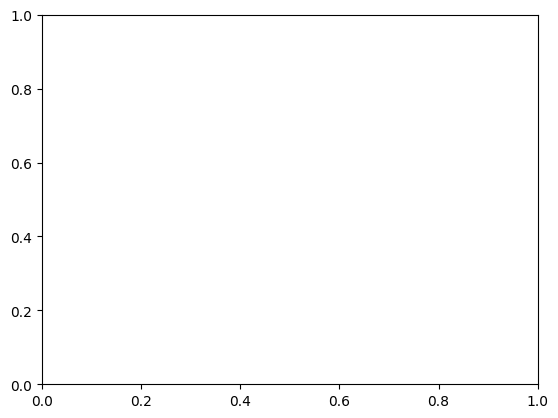

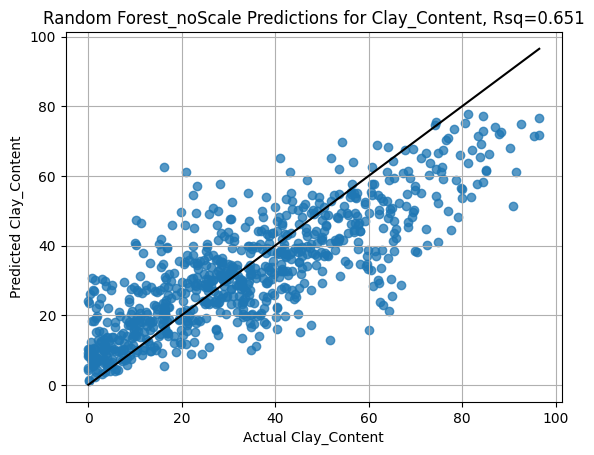

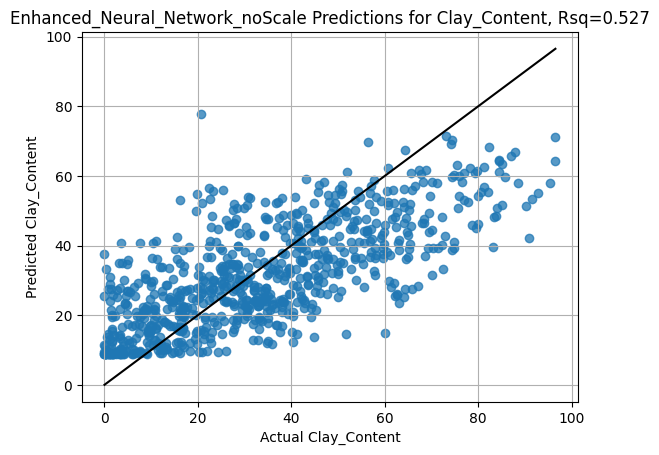

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

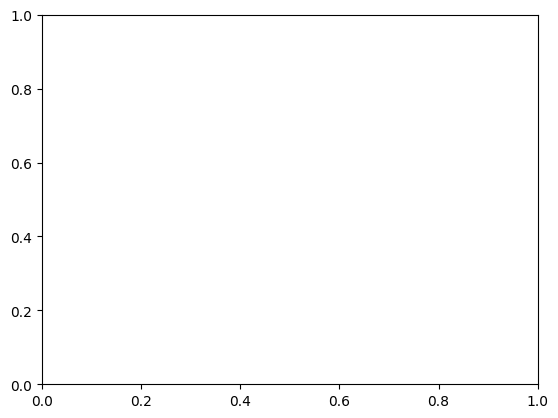

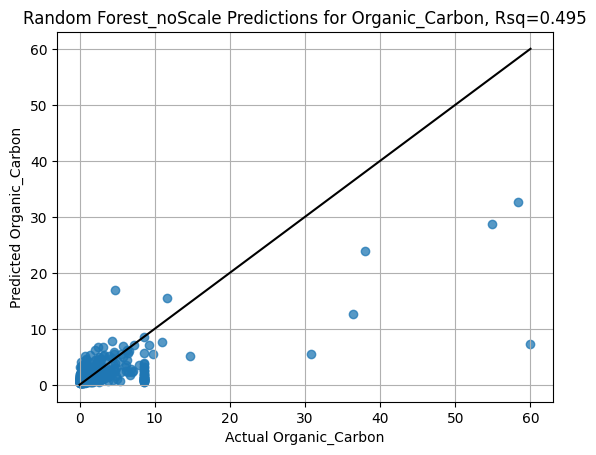

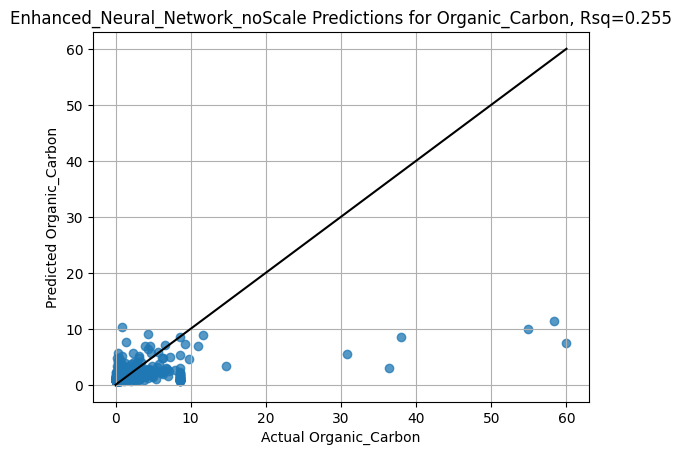

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

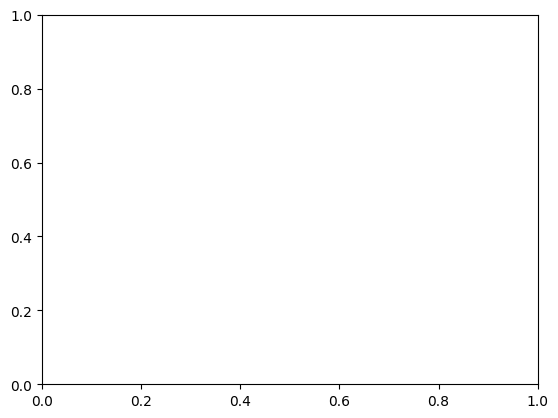

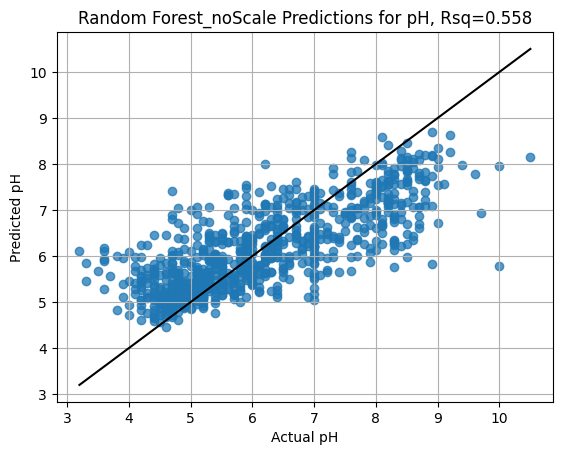

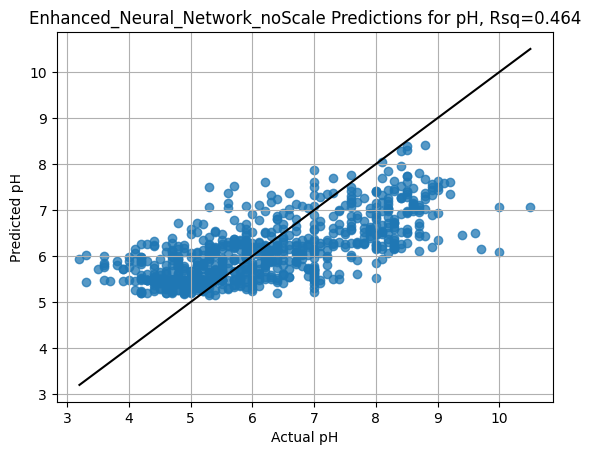

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

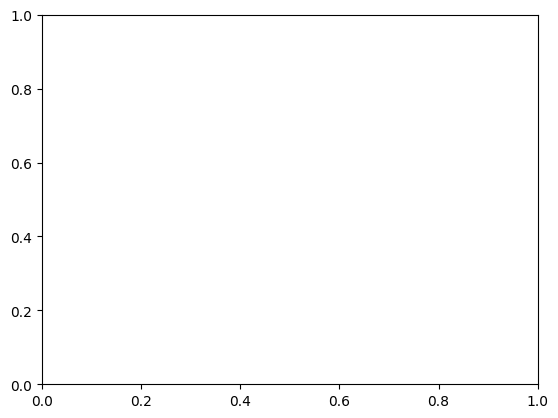

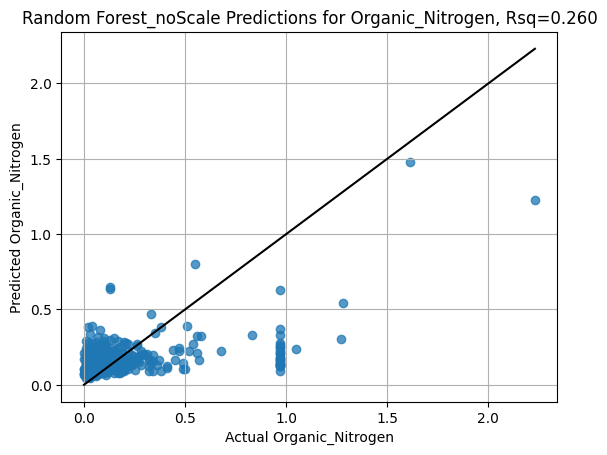

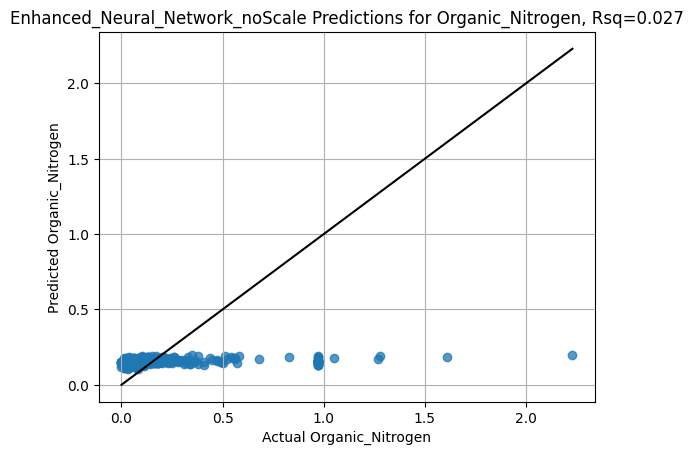

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot results_y_test vs results_y_pred
for prop in results.keys():
    for model_type in results[prop].keys():
        print(f'Plotting {model_type} prediction of {prop}.')
        if results[prop][model_type] is None:
            print('The results are not present.')
        else:
            try:
                plt.figure()
                x = results_y_test[prop][model_type]
                y = results_y_pred[prop][model_type]
                rng = [np.min(x), np.max(x)]
                plt.scatter(x, y, alpha=0.75)
                plt.plot(rng, rng, c='k')
                plt.grid(True)
                plt.xlabel(f'Actual {prop}')
                plt.ylabel(f'Predicted {prop}')
                plt.title(f'{model_type} Predictions for {prop}, Rsq={results[prop][model_type]:.3f}')
            except:
                print('An error occured while plotting.')

In [ ]:
## Using Saved Models for Predictions

# Example of how to use the saved models for new predictions
print("Example: Using saved models for predictions")
print("="*50)

# Method 1: Use the models that are already in memory
print("\nMethod 1: Using models from current session")
print("-" * 45)

# Get a sample from the test data for demonstration
sample_index = 0  # Use first sample as example
try:
    # Get test data for demonstration
    X_test_sample = predictor.scaler.transform(spectra[:1])  # First sample
    
    print(f"Predicting soil properties for sample {sample_index}:")
    for prop in target_properties:
        print(f"\n{prop} predictions:")
        for model_type, model in trained_models[prop].items():
            if model is not None:
                try:
                    if model_type == 'Neural Network':
                        prediction = model.predict(X_test_sample, verbose=0)[0][0]
                    else:
                        prediction = model.predict(X_test_sample)[0]
                    print(f"  {model_type}: {prediction:.3f}")
                except Exception as e:
                    print(f"  {model_type}: Error - {e}")
    
    print(f"\nMethod 2: Loading models from disk")
    print("-" * 40)
    print("# To load models from disk later:")
    print(f"# import joblib")
    print(f"# from tensorflow.keras.models import load_model")
    print(f"# ")
    print(f"# # Load predictor (contains scaler)")
    print(f"# loaded_predictor = joblib.load('{save_dir}/soil_predictor.pkl')")
    print(f"# ")  
    print(f"# # Load individual models")
    print(f"# ph_pls_model = joblib.load('{save_dir}/pH_Enhanced_PLS_model.pkl')")
    print(f"# clay_rf_model = joblib.load('{save_dir}/Clay_Content_RandomForest_model.pkl')")
    print(f"# oc_nn_model = load_model('{save_dir}/Organic_Carbon_Enhanced_NeuralNetwork_model.keras')")
    print(f"# ")
    print(f"# # Make predictions")
    print(f"# new_spectra_scaled = loaded_predictor.scaler.transform(new_spectra)")
    print(f"# ph_prediction = ph_pls_model.predict(new_spectra_scaled)")
    print(f"# clay_prediction = clay_rf_model.predict(new_spectra_scaled)")
    print(f"# oc_prediction = oc_nn_model.predict(new_spectra_scaled)")

except Exception as e:
    print(f"Error in prediction example: {e}")
    print("This is normal if the models haven't been trained yet.")

print(f"\n✅ Models are now automatically saved after training!")
print(f"📁 Check the '{save_dir}' directory for all saved model files.")


## Results Visualization


In [ ]:
# Plot comparison of model performances
plt.figure(figsize=(12, 8))

# Create bar plot
results_df_clean = results_df.fillna(0)  # Replace None with 0 for plotting
ax = results_df_clean.plot(kind='bar', width=0.8)

plt.title('Model Performance Comparison (Test Set R² Scores)\n80/20 Train-Test Split')
plt.xlabel('Soil Properties')
plt.ylabel('Test Set R² Score')
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add horizontal lines for performance levels
plt.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='Excellent (0.9)')
plt.axhline(y=0.7, color='orange', linestyle='--', alpha=0.7, label='Good (0.7)')
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Fair (0.5)')

plt.tight_layout()
plt.show()

# Create heatmap of results
plt.figure(figsize=(10, 6))
sn.heatmap(results_df_clean, annot=True, cmap='RdYlBu_r', fmt='.3f', 
           cbar_kws={'label': 'Test Set R² Score'}, vmin=0, vmax=1)
plt.title('Model Performance Heatmap (Test Set R² Scores)\n80/20 Train-Test Split')
plt.tight_layout()
plt.show()


## Feature Importance Analysis


In [ ]:
def analyze_spectral_importance(predictor, target_property, model_type='random_forest'):
    """
    Analyze which wavelengths are most important for predicting a soil property
    Uses training data from 80/20 split for consistent evaluation
    """
    # Use train-test split for consistency with main evaluation
    X_train, X_test, y_train, y_test = predictor.train_test_split_data(target_property)
    
    if model_type == 'random_forest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        importance = model.feature_importances_
        
        # Evaluate model performance on test set
        test_predictions = model.predict(X_test)
        test_r2 = r2_score(y_test, test_predictions)
        print(f"Random Forest test R² for {target_property}: {test_r2:.3f}")
    
    # Plot feature importance
    plt.figure(figsize=(15, 6))
    plt.plot(wavelengths, importance)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Feature Importance')
    plt.title(f'Spectral Feature Importance for {target_property} Prediction')
    plt.grid(True, alpha=0.3)
    
    # Highlight key absorption regions
    plt.axvspan(400, 500, alpha=0.2, color='blue', label='Visible (400-500nm)')
    plt.axvspan(700, 1000, alpha=0.2, color='red', label='NIR (700-1000nm)')
    plt.axvspan(1000, 1350, alpha=0.2, color='green', label='SWIR1 (1000-1350nm)')
    plt.axvspan(1400, 1800, alpha=0.2, color='orange', label='SWIR2 (1400-1800nm)')
    plt.axvspan(2000, 2500, alpha=0.2, color='purple', label='SWIR3 (2000-2500nm)')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Find top 10 most important wavelengths
    top_indices = np.argsort(importance)[-10:]
    top_wavelengths = wavelengths[top_indices]
    top_importance = importance[top_indices]
    
    print(f"Top 10 most important wavelengths for {target_property}:")
    for i, (wl, imp) in enumerate(zip(top_wavelengths, top_importance)):
        print(f"{i+1:2d}. {wl:4.0f} nm: {imp:.4f}")

# Analyze feature importance for each target property
for prop in target_properties:
    print(f"\nAnalyzing spectral importance for {prop}")
    try:
        analyze_spectral_importance(predictor, prop)
    except Exception as e:
        print(f"Failed to analyze {prop}: {e}")


## Model Deployment Functions


In [ ]:
def predict_soil_properties(new_spectra, predictor, trained_models):
    """
    Predict soil properties for new spectral data
    
    Args:
    - new_spectra: numpy array of new spectral measurements
    - predictor: trained SoilPropertyPredictor instance
    - trained_models: dictionary of trained models for each property
    
    Returns:
    - predictions: dictionary of predicted values for each property
    """
    
    # Standardize new spectra using the same scaler
    new_spectra_scaled = predictor.scaler.transform(new_spectra)
    
    predictions = {}
    
    for prop, model in trained_models.items():
        if model is not None:
            if hasattr(model, 'predict'):
                # Sklearn models
                pred = model.predict(new_spectra_scaled)
            else:
                # Keras models
                pred = model.predict(new_spectra_scaled, verbose=0).flatten()
            
            predictions[prop] = pred
    
    return predictions

def save_models(trained_models, save_dir='saved_models'):
    """
    Save trained models for future use
    """
    import joblib
    import os
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for prop, model in trained_models.items():
        if model is not None:
            if hasattr(model, 'save'):  # Keras model
                model.save(f'{save_dir}/{prop}_nn_model.keras')
            else:  # Sklearn model
                joblib.dump(model, f'{save_dir}/{prop}_model.pkl')
    
    print(f"Models saved to {save_dir}/")

def load_models(save_dir='saved_models'):
    """
    Load previously saved models
    
    Args:
    - save_dir: directory containing saved models
    
    Returns:
    - trained_models: dictionary of loaded models
    """
    import joblib
    import os
    from tensorflow.keras.models import load_model
    
    trained_models = {}
    
    if not os.path.exists(save_dir):
        print(f"Directory {save_dir} does not exist!")
        return trained_models
    
    # List all files in the save directory
    files = os.listdir(save_dir)
    
    for file in files:
        file_path = os.path.join(save_dir, file)
        
        if file.endswith('_nn_model.keras'):
            # Load Keras model
            prop_name = file.replace('_nn_model.keras', '')
            try:
                model = load_model(file_path)
                trained_models[prop_name] = model
                print(f"✓ Loaded Keras model for {prop_name}")
            except Exception as e:
                print(f"✗ Failed to load Keras model {file}: {e}")
                
        elif file.endswith('_model.pkl'):
            # Load sklearn model
            prop_name = file.replace('_model.pkl', '')
            try:
                model = joblib.load(file_path)
                trained_models[prop_name] = model
                print(f"✓ Loaded sklearn model for {prop_name}")
            except Exception as e:
                print(f"✗ Failed to load sklearn model {file}: {e}")
    
    print(f"\nLoaded {len(trained_models)} models from {save_dir}/")
    return trained_models

print("Soil property prediction system ready!")
print("\nTo use this system:")
print("1. Load your soil spectral data")
print("2. Train models on your specific dataset")
print("3. Use trained models to predict soil properties for new samples")
print("4. Validate predictions with known reference values")


## Using Saved Models


In [ ]:
# Diagnostic Analysis for PLS Component Testing
def diagnose_pls_components(predictor, target_property, max_components=15):
    """
    Detailed analysis of PLS component behavior to understand why R² might not change
    """
    import matplotlib.pyplot as plt
    from sklearn.cross_decomposition import PLSRegression
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import r2_score
    import numpy as np
    
    print(f"🔍 DIAGNOSING PLS COMPONENTS FOR {target_property}")
    print("="*60)
    
    # Get data
    X_train, X_test, y_train, y_test = predictor.train_test_split_data(target_property)
    
    # Basic data info
    print(f"Training data: {X_train.shape[0]} samples × {X_train.shape[1]} features")
    print(f"Target range: {y_train.min():.3f} to {y_train.max():.3f}")
    print(f"Target std: {y_train.std():.3f}")
    print(f"Target variance: {y_train.var():.3f}")
    
    # Store detailed results
    component_results = []
    cv_scores_all = []
    explained_variance_X = []
    explained_variance_Y = []
    
    max_components = min(max_components, X_train.shape[1], X_train.shape[0]-1)
    
    print(f"\nTesting 1 to {max_components} components...")
    print("-" * 60)
    
    for n_comp in range(1, max_components + 1):
        # Train PLS model
        pls = PLSRegression(n_components=n_comp)
        pls.fit(X_train, y_train)
        
        # Cross-validation scores
        cv_scores = cross_val_score(pls, X_train, y_train, cv=5, scoring='r2')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Test set score
        test_pred = pls.predict(X_test)
        test_r2 = r2_score(y_test, test_pred)
        
        # Explained variance
        X_transformed = pls.transform(X_train)
        # Approximate explained variance in X
        var_X = np.sum(np.var(X_transformed, axis=0)) / np.sum(np.var(X_train, axis=0))
        
        # Store results
        component_results.append({
            'n_components': n_comp,
            'cv_r2_mean': cv_mean,
            'cv_r2_std': cv_std,
            'test_r2': test_r2,
            'explained_var_X': var_X
        })
        cv_scores_all.append(cv_scores)
        
        # Print detailed results
        print(f"Components {n_comp:2d}: CV R² = {cv_mean:.4f} (±{cv_std:.4f}), "
              f"Test R² = {test_r2:.4f}, Expl.Var.X = {var_X:.3f}")
        
        # Check for convergence
        if n_comp > 1:
            improvement = cv_mean - component_results[-2]['cv_r2_mean']
            if abs(improvement) < 0.001:  # Very small improvement
                print(f"    → Minimal improvement: {improvement:.6f}")
    
    # Analysis and visualization
    results_df = pd.DataFrame(component_results)
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: R² vs Components
    axes[0, 0].plot(results_df['n_components'], results_df['cv_r2_mean'], 'b-o', label='CV R²')
    axes[0, 0].fill_between(results_df['n_components'], 
                           results_df['cv_r2_mean'] - results_df['cv_r2_std'],
                           results_df['cv_r2_mean'] + results_df['cv_r2_std'], 
                           alpha=0.3)
    axes[0, 0].plot(results_df['n_components'], results_df['test_r2'], 'r-s', label='Test R²')
    axes[0, 0].set_xlabel('Number of Components')
    axes[0, 0].set_ylabel('R² Score')
    axes[0, 0].set_title(f'R² vs Components - {target_property}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: R² Differences
    if len(results_df) > 1:
        r2_diff = np.diff(results_df['cv_r2_mean'])
        axes[0, 1].plot(results_df['n_components'][1:], r2_diff, 'g-o')
        axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
        axes[0, 1].set_xlabel('Number of Components')
        axes[0, 1].set_ylabel('R² Improvement')
        axes[0, 1].set_title('R² Improvement per Component')
        axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Explained Variance
    axes[1, 0].plot(results_df['n_components'], results_df['explained_var_X'], 'purple', marker='o')
    axes[1, 0].set_xlabel('Number of Components')
    axes[1, 0].set_ylabel('Explained Variance in X')
    axes[1, 0].set_title('Explained Variance vs Components')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: CV Score Distribution
    cv_scores_array = np.array(cv_scores_all).T
    axes[1, 1].boxplot(cv_scores_array, labels=results_df['n_components'])
    axes[1, 1].set_xlabel('Number of Components')
    axes[1, 1].set_ylabel('Cross-validation R² Scores')
    axes[1, 1].set_title('CV Score Distribution')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary analysis
    print("\n" + "="*60)
    print("📊 ANALYSIS SUMMARY")
    print("="*60)
    
    best_cv_idx = np.argmax(results_df['cv_r2_mean'])
    best_test_idx = np.argmax(results_df['test_r2'])
    
    print(f"Best CV R²: {results_df.iloc[best_cv_idx]['cv_r2_mean']:.4f} "
          f"at {results_df.iloc[best_cv_idx]['n_components']} components")
    print(f"Best Test R²: {results_df.iloc[best_test_idx]['test_r2']:.4f} "
          f"at {results_df.iloc[best_test_idx]['n_components']} components")
    
    # Check for plateau
    if len(results_df) > 3:
        last_3_improvements = np.diff(results_df['cv_r2_mean'].iloc[-4:])
        avg_improvement = np.mean(last_3_improvements)
        
        if abs(avg_improvement) < 0.001:
            print("\n⚠️  PLATEAU DETECTED:")
            print(f"   Average improvement in last 3 components: {avg_improvement:.6f}")
            print("   This indicates the model has reached its optimal performance.")
            print("   Additional components are not providing meaningful improvement.")
        
        # Check for overfitting
        cv_test_diff = results_df['cv_r2_mean'].iloc[-1] - results_df['test_r2'].iloc[-1]
        if cv_test_diff > 0.1:
            print(f"\n⚠️  POTENTIAL OVERFITTING:")
            print(f"   CV R² ({results_df['cv_r2_mean'].iloc[-1]:.4f}) >> Test R² ({results_df['test_r2'].iloc[-1]:.4f})")
            print(f"   Difference: {cv_test_diff:.4f}")
    
    # Data quality checks
    print(f"\n🔍 DATA QUALITY ASSESSMENT:")
    print(f"   Sample size: {len(y_train)} (Good if > 50, Excellent if > 200)")
    print(f"   Target variability (CV): {y_train.std()/y_train.mean():.3f} (Good if > 0.1)")
    
    max_possible_r2 = results_df['cv_r2_mean'].max()
    if max_possible_r2 < 0.3:
        print(f"\n⚠️  LOW PREDICTIVE POWER:")
        print(f"   Maximum achievable R² = {max_possible_r2:.3f}")
        print("   This suggests weak relationship between spectra and target property.")
        print("   Consider:")
        print("   - Data preprocessing (smoothing, derivatives)")
        print("   - Feature selection")
        print("   - Different modeling approach")
    
    return results_df

# Run diagnostics for each target property
print("Running PLS Component Diagnostics...")
for prop in target_properties:
    try:
        diagnose_pls_components(predictor, prop, max_components=10)
        print("\n" + "="*80 + "\n")
    except Exception as e:
        print(f"Failed to diagnose {prop}: {e}")


In [ ]:
# Complete workflow for using saved models with ENVI hyperspectral images

# pip install spectral rasterio

def load_envi_image(envi_file_path, header_file_path=None):
    """
    Load ENVI hyperspectral image file
    
    Args:
    - envi_file_path: path to ENVI image file (.img, .dat, or no extension)
    - header_file_path: path to header file (.hdr) - optional if same name as image
    
    Returns:
    - image_data: 3D numpy array (height, width, bands)
    - wavelengths: 1D numpy array of wavelength values
    - metadata: dictionary with image metadata
    """
    try:
        import spectral
        import numpy as np
        
        # Try to open ENVI file
        if header_file_path:
            img = spectral.open_image(header_file_path, envi_file_path)
        else:
            img = spectral.open_image(envi_file_path)
        
        # Load the image data
        image_data = np.array(img.load())
        
        # Get wavelengths from metadata
        wavelengths = None
        if hasattr(img, 'bands') and hasattr(img.bands, 'centers'):
            wavelengths = np.array(img.bands.centers)
        elif 'wavelength' in img.metadata:
            wavelengths = np.array([float(w) for w in img.metadata['wavelength']])
        else:
            # Create default wavelengths if not available
            n_bands = image_data.shape[2]
            wavelengths = np.arange(400, 400 + n_bands * 5, 5)  # Assume 5nm spacing starting at 400nm
            print("Warning: Wavelength information not found. Using default wavelengths.")
        
        # Extract metadata
        metadata = {
            'shape': image_data.shape,
            'bands': image_data.shape[2],
            'lines': image_data.shape[0],
            'samples': image_data.shape[1],
            'data_type': img.metadata.get('data type', 'unknown'),
            'interleave': img.metadata.get('interleave', 'unknown'),
            'byte_order': img.metadata.get('byte order', 'unknown')
        }
        
        print(f"✓ Loaded ENVI image: {image_data.shape}")
        print(f"  Dimensions: {metadata['lines']} lines × {metadata['samples']} samples × {metadata['bands']} bands")
        print(f"  Wavelength range: {wavelengths.min():.1f} - {wavelengths.max():.1f} nm")
        print(f"  Data type: {metadata['data_type']}")
        
        return image_data, wavelengths, metadata
        
    except ImportError:
        print("Error: 'spectral' library not installed.")
        print("Please install it using: pip install spectral")
        return None, None, None
    except Exception as e:
        print(f"Error loading ENVI file: {e}")
        print("Make sure the file path is correct and the file is a valid ENVI format.")
        return None, None, None

def extract_spectra_from_image(image_data, sample_method='random', n_samples=1000, mask=None):
    """
    Extract spectral samples from hyperspectral image
    
    Args:
    - image_data: 3D numpy array (height, width, bands)
    - sample_method: 'random', 'grid', 'all', or 'mask'
    - n_samples: number of samples to extract (for 'random' and 'grid')
    - mask: 2D boolean array for masked sampling (for 'mask' method)
    
    Returns:
    - spectra: 2D numpy array (n_samples, n_bands)
    - pixel_coords: list of (row, col) coordinates for each sample
    """
    import numpy as np
    
    height, width, n_bands = image_data.shape
    
    if sample_method == 'all':
        # Extract all pixels
        spectra = image_data.reshape(-1, n_bands)
        pixel_coords = [(i, j) for i in range(height) for j in range(width)]
        
    elif sample_method == 'random':
        # Random sampling
        total_pixels = height * width
        n_samples = min(n_samples, total_pixels)
        
        # Generate random pixel coordinates
        indices = np.random.choice(total_pixels, n_samples, replace=False)
        rows = indices // width
        cols = indices % width
        
        spectra = image_data[rows, cols, :]
        pixel_coords = list(zip(rows, cols))
        
    elif sample_method == 'grid':
        # Grid-based sampling
        step_r = max(1, height // int(np.sqrt(n_samples)))
        step_c = max(1, width // int(np.sqrt(n_samples)))
        
        rows = np.arange(0, height, step_r)
        cols = np.arange(0, width, step_c)
        
        row_grid, col_grid = np.meshgrid(rows, cols, indexing='ij')
        row_indices = row_grid.flatten()
        col_indices = col_grid.flatten()
        
        spectra = image_data[row_indices, col_indices, :]
        pixel_coords = list(zip(row_indices, col_indices))
        
    elif sample_method == 'mask' and mask is not None:
        # Masked sampling
        if mask.shape != (height, width):
            raise ValueError("Mask shape must match image spatial dimensions")
        
        valid_rows, valid_cols = np.where(mask)
        n_valid = len(valid_rows)
        
        if n_samples >= n_valid:
            # Use all valid pixels
            spectra = image_data[valid_rows, valid_cols, :]
            pixel_coords = list(zip(valid_rows, valid_cols))
        else:
            # Random sample from valid pixels
            indices = np.random.choice(n_valid, n_samples, replace=False)
            selected_rows = valid_rows[indices]
            selected_cols = valid_cols[indices]
            
            spectra = image_data[selected_rows, selected_cols, :]
            pixel_coords = list(zip(selected_rows, selected_cols))
    
    else:
        raise ValueError("Invalid sample_method. Use 'random', 'grid', 'all', or 'mask'")
    
    # Remove any invalid spectra (e.g., zero or negative values)
    valid_mask = np.all(spectra > 0, axis=1) & np.all(np.isfinite(spectra), axis=1)
    spectra = spectra[valid_mask]
    pixel_coords = [coord for i, coord in enumerate(pixel_coords) if valid_mask[i]]
    
    print(f"✓ Extracted {len(spectra)} valid spectra from image")
    print(f"  Sample method: {sample_method}")
    print(f"  Spectral range: {spectra.min():.4f} - {spectra.max():.4f}")
    
    return spectra, pixel_coords

# Example:
# trained_models = {
#     'Clay_Content': pls_model,  # or rf_model, nn_model
#     'Organic_Carbon': rf_model,
#     'pH': nn_model
# }
# save_models(trained_models, save_dir='saved_models')

# Step 2: Load saved models and predict from ENVI image
def load_and_predict_from_envi(envi_file_path, header_file_path=None, 
                              sample_method='random', n_samples=1000, mask=None):
    """
    Complete workflow: Load ENVI image, extract spectra, and predict soil properties
    
    Args:
    - envi_file_path: path to ENVI hyperspectral image
    - header_file_path: path to header file (optional)
    - sample_method: 'random', 'grid', 'all', or 'mask'
    - n_samples: number of samples to extract and predict
    - mask: 2D boolean array for masked sampling
    
    Returns:
    - predictions: dictionary of predicted soil properties
    - pixel_coords: pixel coordinates for each prediction
    - image_metadata: ENVI image metadata
    """
    
    print("="*60)
    print("SOIL PROPERTY PREDICTION FROM ENVI HYPERSPECTRAL IMAGE")
    print("="*60)
    
    # Step 1: Load previously saved models
    print("\n1. Loading trained models...")
    trained_models = load_models(save_dir='saved_models')
    
    if not trained_models:
        print("❌ No trained models found! Please train and save models first.")
        return None, None, None
    
    # Step 2: Load ENVI hyperspectral image
    print(f"\n2. Loading ENVI image: {envi_file_path}")
    image_data, image_wavelengths, metadata = load_envi_image(envi_file_path, header_file_path)
    
    if image_data is None:
        print("❌ Failed to load ENVI image!")
        return None, None, None
    
    # Step 3: Check wavelength compatibility
    print(f"\n3. Checking wavelength compatibility...")
    print(f"   Training wavelengths: {wavelengths.min():.1f} - {wavelengths.max():.1f} nm ({len(wavelengths)} bands)")
    print(f"   Image wavelengths: {image_wavelengths.min():.1f} - {image_wavelengths.max():.1f} nm ({len(image_wavelengths)} bands)")
    
    # Check if wavelengths match or need interpolation
    if len(image_wavelengths) != len(wavelengths) or not np.allclose(image_wavelengths, wavelengths, atol=1.0):
        print("   ⚠️  Wavelength mismatch detected. Attempting interpolation...")
        
        # Interpolate image spectra to match training wavelengths
        from scipy.interpolate import interp1d
        
        # Extract sample spectra first
        print(f"\n4. Extracting spectra from image...")
        raw_spectra, pixel_coords = extract_spectra_from_image(
            image_data, sample_method=sample_method, n_samples=n_samples, mask=mask
        )
        
        # Interpolate each spectrum
        interpolated_spectra = []
        for spectrum in raw_spectra:
            # Create interpolation function
            f = interp1d(image_wavelengths, spectrum, kind='linear', 
                        bounds_error=False, fill_value='extrapolate')
            # Interpolate to training wavelengths
            interpolated_spectrum = f(wavelengths)
            interpolated_spectra.append(interpolated_spectrum)
        
        new_spectra = np.array(interpolated_spectra)
        print(f"   ✓ Interpolated spectra to match training wavelengths")
        
    else:
        print("   ✓ Wavelengths match training data")
        
        # Extract spectra from image
        print(f"\n4. Extracting spectra from image...")
        new_spectra, pixel_coords = extract_spectra_from_image(
            image_data, sample_method=sample_method, n_samples=n_samples, mask=mask
        )
    
    print(f"   Final spectral data shape: {new_spectra.shape}")
    
    # Step 4: Normalize spectra if needed (convert to reflectance 0-1 range)
    if new_spectra.max() > 1.0:
        print("   📊 Converting to reflectance (0-1 range)...")
        if new_spectra.max() > 10000:  # Likely scaled reflectance (0-10000)
            new_spectra = new_spectra / 10000.0
        elif new_spectra.max() > 100:  # Likely percentage (0-100)
            new_spectra = new_spectra / 100.0
        print(f"   ✓ Normalized spectral range: {new_spectra.min():.4f} - {new_spectra.max():.4f}")
    
    # Step 5: Make predictions using the loaded models
    print(f"\n5. Making predictions for {len(new_spectra)} pixels...")
    predictions = predict_soil_properties(new_spectra, predictor, trained_models)
    
    # Step 6: Display results summary
    print(f"\n6. Prediction Results Summary:")
    print("="*40)
    
    for prop, pred_values in predictions.items():
        if isinstance(pred_values, np.ndarray) and len(pred_values) > 0:
            print(f"{prop}:")
            print(f"  Mean: {np.mean(pred_values):.3f}")
            print(f"  Std:  {np.std(pred_values):.3f}")
            print(f"  Min:  {np.min(pred_values):.3f}")
            print(f"  Max:  {np.max(pred_values):.3f}")
        print()
    
    return predictions, pixel_coords, metadata

def load_and_predict_example_synthetic():
    """
    Example with synthetic data (fallback if no ENVI file available)
    """
    print("Using synthetic data for demonstration...")
    
    # Load previously saved models
    trained_models = load_models(save_dir='saved_models')
    
    if not trained_models:
        print("❌ No trained models found! Please train and save models first.")
        return None
    
    # Generate example synthetic spectral data
    n_new_samples = 5
    n_wavelengths = len(wavelengths)
    
    np.random.seed(123)
    new_spectra = np.random.normal(0.3, 0.1, (n_new_samples, n_wavelengths))
    new_spectra = np.clip(new_spectra, 0.01, 1.0)
    
    print(f"Synthetic spectral data shape: {new_spectra.shape}")
    
    # Make predictions
    predictions = predict_soil_properties(new_spectra, predictor, trained_models)
    
    print("\n" + "="*50)
    print("PREDICTIONS FOR SYNTHETIC SOIL SAMPLES")
    print("="*50)
    
    for i in range(n_new_samples):
        print(f"\nSample {i+1}:")
        for prop, pred_values in predictions.items():
            if isinstance(pred_values, np.ndarray):
                print(f"  {prop}: {pred_values[i]:.3f}")
            else:
                print(f"  {prop}: {pred_values:.3f}")
    
    return predictions

# Step 3: Analyze prediction quality and soil suitability
def analyze_predictions(predictions):
    """
    Analyze predictions and calculate soil suitability scores
    """
    n_samples = len(next(iter(predictions.values())))
    
    print("\n" + "="*50)
    print("SOIL SUITABILITY ANALYSIS")
    print("="*50)
    
    for i in range(n_samples):
        print(f"\nSample {i+1} Analysis:")
        
        # Create soil properties dictionary for this sample
        soil_props = {}
        for prop, pred_values in predictions.items():
            if isinstance(pred_values, np.ndarray):
                soil_props[prop] = pred_values[i]
            else:
                soil_props[prop] = pred_values
        
        # Calculate crop suitability score
        suitability = calculate_crop_suitability_score(soil_props)
        
        print(f"  Overall Score: {suitability['overall_score']:.1f}/100")
        print(f"  Classification: {suitability['classification']}")
        
        # Show individual property scores
        print("  Property Scores:")
        for prop, score in suitability['property_scores'].items():
            if score is not None:
                print(f"    {prop}: {score:.1f}/100")
        
        # Show limiting factors
        limiting = identify_limiting_factors(soil_props)
        if limiting['limiting_factors']:
            print("  Limiting Factors:")
            for factor, score in limiting['limiting_factors']:
                print(f"    {factor}: {score:.1f}/100")
            
            print("  Recommendations:")
            for rec in limiting['recommendations']:
                print(f"    - {rec}")

def create_prediction_maps(predictions, pixel_coords, image_shape, properties_to_map=None):
    """
    Create 2D prediction maps from pixel predictions
    
    Args:
    - predictions: dictionary of predicted soil properties
    - pixel_coords: list of (row, col) coordinates for each prediction
    - image_shape: (height, width) of the original image
    - properties_to_map: list of properties to create maps for (default: all)
    
    Returns:
    - prediction_maps: dictionary of 2D numpy arrays (property maps)
    """
    import numpy as np
    
    if properties_to_map is None:
        properties_to_map = list(predictions.keys())
    
    prediction_maps = {}
    height, width = image_shape[:2]
    
    for prop in properties_to_map:
        if prop in predictions:
            # Initialize map with NaN values
            prop_map = np.full((height, width), np.nan)
            
            # Fill in predictions at pixel locations
            pred_values = predictions[prop]
            if isinstance(pred_values, np.ndarray):
                for i, (row, col) in enumerate(pixel_coords):
                    if 0 <= row < height and 0 <= col < width:
                        prop_map[row, col] = pred_values[i]
            
            prediction_maps[prop] = prop_map
            
            # Print map statistics
            valid_pixels = ~np.isnan(prop_map)
            n_valid = np.sum(valid_pixels)
            if n_valid > 0:
                print(f"✓ Created {prop} map: {n_valid}/{height*width} pixels predicted")
                print(f"  Range: {np.nanmin(prop_map):.3f} - {np.nanmax(prop_map):.3f}")
    
    return prediction_maps

def save_prediction_maps_as_geotiff(prediction_maps, metadata=None, output_dir='prediction_maps', 
                                   coordinate_system='EPSG:4326', pixel_size=None, geotransform=None):
    """
    Save soil property prediction maps as GeoTIFF files
    
    Args:
    - prediction_maps: dictionary of 2D prediction arrays
    - metadata: ENVI image metadata containing spatial information
    - output_dir: directory to save GeoTIFF files
    - coordinate_system: coordinate reference system (default: WGS84)
    - pixel_size: tuple of (x_pixel_size, y_pixel_size) in map units
    - geotransform: rasterio-style geotransform tuple (upper_left_x, pixel_width, rotation, upper_left_y, rotation, pixel_height)
    
    Returns:
    - saved_files: list of saved GeoTIFF file paths
    """
    try:
        import rasterio
        from rasterio.transform import from_bounds, Affine
        from rasterio.crs import CRS
        import numpy as np
        import os
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        saved_files = []
        
        if len(prediction_maps) == 0:
            print("No prediction maps to save!")
            return saved_files
        
        # Get map dimensions from first prediction map
        first_map = next(iter(prediction_maps.values()))
        height, width = first_map.shape
        
        # Set up coordinate reference system
        try:
            crs = CRS.from_string(coordinate_system)
        except:
            print(f"Warning: Could not parse CRS '{coordinate_system}', using WGS84")
            crs = CRS.from_epsg(4326)
        
        # Set up geospatial transform
        if geotransform:
            # Use provided geotransform
            transform = Affine(*geotransform)
            print(f"Using provided geotransform: {geotransform}")
        elif metadata and 'map_info' in metadata:
            # Try to extract coordinate information from ENVI metadata
            print("Extracting geospatial information from ENVI metadata...")
            # ENVI map info format: {projection, ref_x, ref_y, x_map_coord, y_map_coord, x_pixel_size, y_pixel_size, projection_info...}
            map_info = metadata['map_info']
            # This would need to be parsed based on actual ENVI format
            # For now, use default approach
            transform = rasterio.transform.from_bounds(0, 0, width, height, width, height)
        elif pixel_size:
            # Use provided pixel size
            x_size, y_size = pixel_size
            # Create transform with pixel size (assuming upper-left origin)
            transform = Affine(x_size, 0.0, 0.0, 0.0, -abs(y_size), 0.0)
            print(f"Using pixel size: {x_size} x {y_size}")
        else:
            # Default transform (pixel coordinates)
            print("Warning: No spatial reference found. Using pixel coordinates.")
            transform = rasterio.transform.from_bounds(0, 0, width, height, width, height)
        
        print(f"Saving {len(prediction_maps)} prediction maps as GeoTIFF files...")
        
        for prop, pred_map in prediction_maps.items():
            # Create output filename
            safe_prop_name = prop.replace(' ', '_').replace('/', '_').replace('%', 'pct')
            output_file = os.path.join(output_dir, f'{safe_prop_name}_prediction.tif')
            
            # Convert to float32 for GeoTIFF
            pred_map_float = pred_map.astype(np.float32)
            
            # Set up rasterio profile
            profile = {
                'driver': 'GTiff',
                'height': height,
                'width': width,
                'count': 1,  # Single band
                'dtype': rasterio.float32,
                'crs': crs,
                'transform': transform,
                'compress': 'lzw',  # Compression for smaller files
                'nodata': np.nan  # Use NaN for no-data values
            }
            
            # Write GeoTIFF file
            with rasterio.open(output_file, 'w', **profile) as dst:
                dst.write(pred_map_float, 1)  # Write to band 1
                
                # Add band description
                dst.set_band_description(1, f'{prop} Prediction')
                
                # Add metadata
                dst.update_tags(
                    **{
                        'DESCRIPTION': f'Soil property prediction: {prop}',
                        'PROPERTY': prop,
                        'SOURCE': 'Hyperspectral soil property prediction model',
                        'UNITS': get_property_units(prop),
                        'CREATION_DATE': str(pd.Timestamp.now()),
                        'COORDINATE_SYSTEM': str(crs),
                        'SOFTWARE': 'soil-hyperspectral-prediction-model'
                    }
                )
            
            saved_files.append(output_file)
            
            # Print statistics
            valid_pixels = ~np.isnan(pred_map_float)
            n_valid = np.sum(valid_pixels)
            if n_valid > 0:
                print(f"✓ Saved {prop}: {output_file}")
                print(f"  Valid pixels: {n_valid}/{height*width}")
                print(f"  Range: {np.nanmin(pred_map_float):.3f} - {np.nanmax(pred_map_float):.3f}")
                print(f"  Units: {get_property_units(prop)}")
            else:
                print(f"⚠️  Warning: {prop} has no valid predictions")
        
        print(f"\n✅ Successfully saved {len(saved_files)} GeoTIFF files to: {output_dir}")
        print(f"📂 Files can be opened in GIS software:")
        print(f"   • QGIS: Add Layer → Add Raster Layer")
        print(f"   • ArcGIS: Add Data → Raster")
        print(f"   • Python: rasterio.open('file.tif')")
        
        return saved_files
        
    except ImportError:
        print("❌ Error: 'rasterio' library not installed.")
        print("Please install it using: pip install rasterio")
        return []
    except Exception as e:
        print(f"❌ Error saving GeoTIFF files: {e}")
        import traceback
        traceback.print_exc()
        return []

def get_property_units(prop):
    """Get appropriate units for soil properties"""
    prop_lower = prop.lower()
    if 'ph' in prop_lower:
        return 'pH units'
    elif any(word in prop_lower for word in ['clay', 'sand', 'silt', 'organic']):
        return 'percent (%)'
    elif any(word in prop_lower for word in ['nitrogen', 'phosphorus', 'potassium']):
        return 'mg/kg'
    elif 'carbon' in prop_lower:
        return 'percent (%)'
    elif any(word in prop_lower for word in ['moisture', 'water']):
        return 'percent (%)'
    else:
        return 'unitless'

def visualize_prediction_maps(prediction_maps, save_plots=True, save_geotiff=True, 
                            output_dir='prediction_maps', metadata=None, 
                            coordinate_system='EPSG:4326', pixel_size=None, geotransform=None):
    """
    Visualize soil property prediction maps and optionally save as PNG and/or GeoTIFF
    
    Args:
    - prediction_maps: dictionary of 2D prediction arrays
    - save_plots: whether to save plot images as PNG
    - save_geotiff: whether to save prediction maps as GeoTIFF files
    - output_dir: directory to save files
    - metadata: ENVI image metadata for geospatial information
    - coordinate_system: coordinate reference system for GeoTIFF files (e.g., 'EPSG:4326', 'EPSG:32633')
    - pixel_size: tuple of (x_pixel_size, y_pixel_size) in map units (e.g., (30, 30) for 30m pixels)
    - geotransform: rasterio-style geotransform tuple for precise georeferencing
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    
    if (save_plots or save_geotiff) and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    n_props = len(prediction_maps)
    if n_props == 0:
        print("No prediction maps to visualize!")
        return
    
    # Save as GeoTIFF files if requested
    if save_geotiff:
        print("Saving prediction maps as GeoTIFF files...")
        saved_tiff_files = save_prediction_maps_as_geotiff(
            prediction_maps, 
            metadata=metadata, 
            output_dir=output_dir, 
            coordinate_system=coordinate_system,
            pixel_size=pixel_size,
            geotransform=geotransform
        )
    
    # Create visualization plots
    print("Creating visualization plots...")
    
    # Create subplots
    fig, axes = plt.subplots(1, n_props, figsize=(5*n_props, 5))
    if n_props == 1:
        axes = [axes]
    
    for i, (prop, pred_map) in enumerate(prediction_maps.items()):
        ax = axes[i]
        
        # Create colormap plot
        im = ax.imshow(pred_map, cmap='viridis', interpolation='nearest')
        ax.set_title(f'{prop} Predictions')
        ax.set_xlabel('Column (pixels)')
        ax.set_ylabel('Row (pixels)')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.8)
        
        # Set colorbar label with units
        units = get_property_units(prop)
        cbar.set_label(f'{prop} ({units})')
    
    plt.tight_layout()
    
    # Save PNG plot if needed
    if save_plots:
        plot_path = os.path.join(output_dir, 'soil_property_maps_visualization.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Saved visualization plot to: {plot_path}")
    
    plt.show()
    
    # Print summary
    print(f"\nOUTPUT SUMMARY:")
    if save_geotiff:
        print(f"   GeoTIFF files saved to: {output_dir}/")
        print(f"   Files can be opened in GIS software (QGIS, ArcGIS, etc.)")
        print(f"   Coordinate system: {coordinate_system}")
        if pixel_size:
            print(f"   Pixel size: {pixel_size[0]} x {pixel_size[1]} map units")
    if save_plots:
        print(f"   Visualization PNG saved to: {output_dir}/")
    
    total_files = n_props * (1 if save_geotiff else 0) + (1 if save_plots else 0)
    print(f"   Total files created: {total_files}")

def save_prediction_maps_with_coordinates(prediction_maps, pixel_coords, output_dir='prediction_maps',
                                        coordinate_system='EPSG:4326', bounds=None):
    """
    Save prediction maps as GeoTIFF with proper geographic coordinates
    
    Args:
    - prediction_maps: dictionary of 2D prediction arrays
    - pixel_coords: list of (row, col) pixel coordinates
    - output_dir: directory to save files
    - coordinate_system: CRS for the output files
    - bounds: tuple of (min_x, min_y, max_x, max_y) in map coordinates
    """
    if bounds is None:
        print("Warning: No geographic bounds provided. Using default pixel coordinates.")
        # Get image dimensions
        first_map = next(iter(prediction_maps.values()))
        height, width = first_map.shape
        bounds = (0, 0, width, height)
    
    min_x, min_y, max_x, max_y = bounds
    
    # Calculate pixel size
    first_map = next(iter(prediction_maps.values()))
    height, width = first_map.shape
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    
    # Create geotransform (upper-left origin)
    geotransform = (min_x, pixel_size_x, 0.0, max_y, 0.0, -pixel_size_y)
    
    print(f"Geographic bounds: {bounds}")
    print(f"Calculated pixel size: {pixel_size_x:.6f} x {pixel_size_y:.6f}")
    
    return save_prediction_maps_as_geotiff(
        prediction_maps,
        output_dir=output_dir,
        coordinate_system=coordinate_system,
        geotransform=geotransform
    )
